## Siemens PCA and FPCA as outlier detector

This code shows the implementation of PCA and FPCA for reducing the dimension of the multiple time series.
It adds the scores and identify the time series which contribute the most to the principal components.
However, after some research the main benefit of this technique relies on visualization of two components which summarize all the curves and as outlier detection due to its sensibility to campture patterns in the data.

For instance, if commenting the block of code "Data cleaning - Removing unsuccessful return codes" and runing PCA and FPCA on "A1_cal_window" we can observe how the second component displays a peak. However, when removing the unsuccessful return codes as was suggested by Siemens in the meeting of May 17th, we can see this pattern dissapears.

**Index**

1. Loading the datasets
2. Transposing the time series datasets
3. Merging time series datasets to add additional features
4. Identifying TestID with bad return codes
5. Data cleaning - Removing unsuccessful return codes
6. Filtering and spliting in Blood and Aquous groups
7. Window extraction
8. Removing partial or full series with missing values after the window extraction
9. Function to plot time series in one plot
10. PCA
11. Functional PCA
12. Verifying waveforms which contributes the most to PC's shape

## 1. Loading the datasets

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 2. Transposing the time series datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import datasets
path = "drive/MyDrive"
sensorA_System1 = pd.read_csv(path+"/System1_SensorA.csv")
sensorA_System2 = pd.read_csv(path+"/System2_SensorA.csv")
sensorB_System1 = pd.read_csv(path+"/System1_SensorB.csv")
sensorB_System2 = pd.read_csv(path+"/System2_SensorB.csv")
keyByTestID = pd.read_csv(path+"/Key by TestID.csv", parse_dates=['DateTime'])

## 3. Merging time series datasets to add additional features

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Merge dataset with keyByTestID and delete unmatched tests
# Sensor A
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]

# Merge dataset with keyByTestID
# Sensor B
B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B2_transposed = B2_transposed[B2_transposed['TestID'].isin(B2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3407, 2694)
A2:  (7781, 1319)
B1:  (3398, 3376)
B2:  (7780, 3367)


## 4. Identifying TestID with bad return codes

In [6]:
A1_Merged_bad_returncodes = A1_Merged[~A1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
A2_Merged_bad_returncodes = A2_Merged[~A2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B1_Merged_bad_returncodes = B1_Merged[~B1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B2_Merged_bad_returncodes = B2_Merged[~B2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()

print('A1_Merged_bad_returncodes')
print(A1_Merged_bad_returncodes['TestID'])
print('\nA2_Merged_bad_returncodes\n')
print(A2_Merged_bad_returncodes['TestID'])
print('\nB1_Merged_bad_returncodes\n')
print(B1_Merged_bad_returncodes['TestID'])
print('\nB2_Merged_bad_returncodes\n')
print(B2_Merged_bad_returncodes['TestID'])

A1_Merged_bad_returncodes
0       12414199
44      12416289
48      12416278
122     12446029
201     12486850
492     12601278
728     12191442
995     12514810
1051    12515535
1091    12515705
1205    12480292
1207    12623120
1242    12597803
1355    12530207
1602    12530199
1915    12472338
2060    12530446
2071    12530379
2261    12557613
2301    12470796
2352    12529229
2374    12390613
2652    12371902
2826    12529328
3095    12531249
Name: TestID, dtype: int64

A2_Merged_bad_returncodes

608     3561473
859     3545381
1085    3547411
1258    3548457
1698    3553569
1728    3553619
1983    3555557
2258    3557972
2497    3561799
2688    3564315
2877    3565626
2889    3565643
2924    3565699
2944    3565740
3009    3565982
3039    3566065
3046    3566584
3072    3566624
3115    3566834
3117    3566837
3118    3566838
3171    3566963
3806    3552740
3921    3552653
4039    3569098
5523    3555888
5577    3555913
5608    3558047
6242    3558380
6950    3567852
7145    355160

## 5. Data cleaning - Removing unsuccessful return codes

In [7]:
A1_Merged = A1_Merged[A1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
A2_Merged = A2_Merged[A2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B1_Merged = B1_Merged[B1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B2_Merged = B2_Merged[B2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()

A1_Merged.reset_index(drop=True, inplace=True)
A2_Merged.reset_index(drop=True, inplace=True)
B1_Merged.reset_index(drop=True, inplace=True)
B2_Merged.reset_index(drop=True, inplace=True)

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 2694)
A2:  (7743, 1319)
B1:  (3375, 3376)
B2:  (7745, 3367)


## 6. Filtering and spliting in Blood and Aquous groups

In [8]:
# Blood
A1_blood_Merged = A1_Merged[A1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A2_blood_Merged = A2_Merged[A2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A1_blood_Merged.reset_index(drop=True, inplace=True)
A2_blood_Merged.reset_index(drop=True, inplace=True)

# Aquous
A1_aquous_Merged = A1_Merged[~A1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A2_aquous_Merged = A2_Merged[~A2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A1_aquous_Merged.reset_index(drop=True, inplace=True)
A2_aquous_Merged.reset_index(drop=True, inplace=True)

# Blood
B1_blood_Merged = (B1_Merged[B1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B2_blood_Merged = (B2_Merged[B2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B1_blood_Merged.reset_index(drop=True, inplace=True)
B2_blood_Merged.reset_index(drop=True, inplace=True)

# Aquous
B1_aquous_Merged = (B1_Merged[~B1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B2_aquous_Merged = (B2_Merged[~B2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B1_aquous_Merged.reset_index(drop=True, inplace=True)
B2_aquous_Merged.reset_index(drop=True, inplace=True)

## 7. Window extraction

In [9]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Match window values of Sensor B for each test

# Blood
calDelLimit_sensorB_blood = 20
sampleDelLimit_sensorB_blood = 24
calWindowSize_sensorB_blood = 18
sampleWindowSize_sensorB_blood = 4

# Aquous
calDelLimit_sensorB_aqueous = 20
sampleDelLimit_sensorB_aqueous = 30
calWindowSize_sensorB_aqueous = 18
sampleWindowSize_sensorB_aqueous = 4

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit_input, cal_window_size_input, sampleDelimit_input, sample_window_size_input):
    cal_window_start = bubble_start - calDelimit_input
    cal_window_end = cal_window_start + cal_window_size_input
    sample_window_start = sample_start + sampleDelimit_input
    sample_window_end = sample_window_start + sample_window_size_input
    return round(cal_window_start,1), round(cal_window_end,1), round(sample_window_start,1), round(sample_window_end,1)

# Sensor A
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# Sensor A - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_blood_Merged['cal_window_start']=cal_window_start
A1_blood_Merged['cal_window_end']=cal_window_end
A1_blood_Merged['sample_window_start']=sample_window_start
A1_blood_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_blood_Merged['cal_window_start']=cal_window_start
A2_blood_Merged['cal_window_end']=cal_window_end
A2_blood_Merged['sample_window_start']=sample_window_start
A2_blood_Merged['sample_window_end']=sample_window_end


# Sensor A - Aquous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_aquous_Merged['cal_window_start']=cal_window_start
A1_aquous_Merged['cal_window_end']=cal_window_end
A1_aquous_Merged['sample_window_start']=sample_window_start
A1_aquous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_aquous_Merged['cal_window_start']=cal_window_start
A2_aquous_Merged['cal_window_end']=cal_window_end
A2_aquous_Merged['sample_window_start']=sample_window_start
A2_aquous_Merged['sample_window_end']=sample_window_end

# Sensor B - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B1_blood_Merged['cal_window_start']=cal_window_start
B1_blood_Merged['cal_window_end']=cal_window_end
B1_blood_Merged['sample_window_start']=sample_window_start
B1_blood_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B2_blood_Merged['cal_window_start']=cal_window_start
B2_blood_Merged['cal_window_end']=cal_window_end
B2_blood_Merged['sample_window_start']=sample_window_start
B2_blood_Merged['sample_window_end']=sample_window_end


# Sensor B - Aquous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B1_aquous_Merged['cal_window_start']=cal_window_start
B1_aquous_Merged['cal_window_end']=cal_window_end
B1_aquous_Merged['sample_window_start']=sample_window_start
B1_aquous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B2_aquous_Merged['cal_window_start']=cal_window_start
B2_aquous_Merged['cal_window_end']=cal_window_end
B2_aquous_Merged['sample_window_start']=sample_window_start
B2_aquous_Merged['sample_window_end']=sample_window_end

In [10]:

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B2_blood_Merged['cal_window_start']=cal_window_start
B2_blood_Merged['cal_window_end']=cal_window_end
B2_blood_Merged['sample_window_start']=sample_window_start
B2_blood_Merged['sample_window_end']=sample_window_end

In [11]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[18:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - Blood

A1_blood_cal_window = []
A1_blood_sample_window = []
for i in range(len(A1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A1_blood_Merged.iloc[i, :])
    A1_blood_cal_window.append(cal_window.values)
    A1_blood_sample_window.append(sample_window.values)
A1_blood_cal_window = pd.DataFrame(A1_blood_cal_window)
A1_blood_sample_window = pd.DataFrame(A1_blood_sample_window)
A1_blood_cal_window['TestID'] = A1_blood_sample_window['TestID'] = A1_blood_Merged['TestID']
A1_blood_sample_window.set_index('TestID',inplace=True)
A1_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - Aquous

A1_aquous_cal_window = []
A1_aquous_sample_window = []
for i in range(len(A1_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(A1_aquous_Merged.iloc[i, :])
    A1_aquous_cal_window.append(cal_window.values)
    A1_aquous_sample_window.append(sample_window.values)
A1_aquous_cal_window = pd.DataFrame(A1_aquous_cal_window)
A1_aquous_sample_window = pd.DataFrame(A1_aquous_sample_window)
A1_aquous_cal_window['TestID'] = A1_aquous_sample_window['TestID'] = A1_aquous_Merged['TestID']
A1_aquous_sample_window.set_index('TestID',inplace=True)
A1_aquous_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - Blood

A2_blood_cal_window = []
A2_blood_sample_window = []
for i in range(len(A2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A2_blood_Merged.iloc[i, :])
    A2_blood_cal_window.append(cal_window.values)
    A2_blood_sample_window.append(sample_window.values)
A2_blood_cal_window = pd.DataFrame(A2_blood_cal_window)
A2_blood_sample_window = pd.DataFrame(A2_blood_sample_window)
A2_blood_cal_window['TestID'] = A2_blood_sample_window['TestID'] = A2_blood_Merged['TestID']
A2_blood_sample_window.set_index('TestID',inplace=True)
A2_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - Aquous

A2_aquous_cal_window = []
A2_aquous_sample_window = []
for i in range(len(A2_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(A2_aquous_Merged.iloc[i, :])
    A2_aquous_cal_window.append(cal_window.values)
    A2_aquous_sample_window.append(sample_window.values)
A2_aquous_cal_window = pd.DataFrame(A2_aquous_cal_window)
A2_aquous_sample_window = pd.DataFrame(A2_aquous_sample_window)
A2_aquous_cal_window['TestID'] = A2_aquous_sample_window['TestID'] = A2_aquous_Merged['TestID']
A2_aquous_sample_window.set_index('TestID',inplace=True)
A2_aquous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Blood

B1_blood_cal_window = []
B1_blood_sample_window = []
for i in range(len(B1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B1_blood_Merged.iloc[i, :])
    B1_blood_cal_window.append(cal_window.values)
    B1_blood_sample_window.append(sample_window.values)
B1_blood_cal_window = pd.DataFrame(B1_blood_cal_window)
B1_blood_sample_window = pd.DataFrame(B1_blood_sample_window)
B1_blood_cal_window['TestID'] = B1_blood_sample_window['TestID'] = B1_blood_Merged['TestID']
B1_blood_sample_window.set_index('TestID',inplace=True)
B1_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B - Blood

B2_blood_cal_window = []
B2_blood_sample_window = []
for i in range(len(B2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B2_blood_Merged.iloc[i, :])
    B2_blood_cal_window.append(cal_window.values)
    B2_blood_sample_window.append(sample_window.values)
B2_blood_cal_window = pd.DataFrame(B2_blood_cal_window)
B2_blood_sample_window = pd.DataFrame(B2_blood_sample_window)
B2_blood_cal_window['TestID'] = B2_blood_sample_window['TestID'] = B2_blood_Merged['TestID']
B2_blood_sample_window.set_index('TestID',inplace=True)
B2_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aquous

B1_aquous_cal_window = []
B1_aquous_sample_window = []
for i in range(len(B1_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(B1_aquous_Merged.iloc[i, :])
    B1_aquous_cal_window.append(cal_window.values)
    B1_aquous_sample_window.append(sample_window.values)
B1_aquous_cal_window = pd.DataFrame(B1_aquous_cal_window)
B1_aquous_sample_window = pd.DataFrame(B1_aquous_sample_window)
B1_aquous_cal_window['TestID'] = B1_aquous_sample_window['TestID'] = B1_aquous_Merged['TestID']
B1_aquous_sample_window.set_index('TestID',inplace=True)
B1_aquous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aquous

B2_aquous_cal_window = []
B2_aquous_sample_window = []
for i in range(len(B2_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(B2_aquous_Merged.iloc[i, :])
    B2_aquous_cal_window.append(cal_window.values)
    B2_aquous_sample_window.append(sample_window.values)
B2_aquous_cal_window = pd.DataFrame(B2_aquous_cal_window)
B2_aquous_sample_window = pd.DataFrame(B2_aquous_sample_window)
B2_aquous_cal_window['TestID'] = B2_aquous_sample_window['TestID'] = B2_aquous_Merged['TestID']
B2_aquous_sample_window.set_index('TestID',inplace=True)
B2_aquous_cal_window.set_index('TestID',inplace=True)

## 8. Removing partial or full series with missing values after the window extraction

In [12]:
# # keep na index
A1_cal_window_drop_index = A1_cal_window.loc[A1_cal_window.isna().sum(axis=1)!=0].index
A2_cal_window_drop_index = A2_cal_window.loc[A2_cal_window.isna().sum(axis=1)!=0].index

A1_blood_cal_window_drop_index = A1_blood_cal_window.loc[A1_blood_cal_window.isna().sum(axis=1)!=0].index
A1_aquous_cal_window_drop_index = A1_aquous_cal_window.loc[A1_aquous_cal_window.isna().sum(axis=1)!=0].index
A2_blood_cal_window_drop_index = A2_blood_cal_window.loc[A2_blood_cal_window.isna().sum(axis=1)!=0].index
A2_aquous_cal_window_drop_index = A2_aquous_cal_window.loc[A2_aquous_cal_window.isna().sum(axis=1)!=0].index

B1_blood_cal_window_drop_index = B1_blood_cal_window.loc[B1_blood_cal_window.isna().sum(axis=1)!=0].index
B1_aquous_cal_window_drop_index = B1_aquous_cal_window.loc[B1_aquous_cal_window.isna().sum(axis=1)!=0].index
B2_blood_cal_window_drop_index = B2_blood_cal_window.loc[B2_blood_cal_window.isna().sum(axis=1)!=0].index
B2_aquous_cal_window_drop_index = B2_aquous_cal_window.loc[B2_aquous_cal_window.isna().sum(axis=1)!=0].index

A1_sample_window_drop_index = A1_sample_window.loc[A1_sample_window.isna().sum(axis=1)!=0].index
A2_sample_window_drop_index = A2_sample_window.loc[A2_sample_window.isna().sum(axis=1)!=0].index

A1_blood_sample_window_drop_index = A1_blood_sample_window.loc[A1_blood_sample_window.isna().sum(axis=1)!=0].index
A1_aquous_sample_window_drop_index = A1_aquous_sample_window.loc[A1_aquous_sample_window.isna().sum(axis=1)!=0].index
A2_blood_sample_window_drop_index = A2_blood_sample_window.loc[A2_blood_sample_window.isna().sum(axis=1)!=0].index
A2_aquous_sample_window_drop_index = A2_aquous_sample_window.loc[A2_aquous_sample_window.isna().sum(axis=1)!=0].index

B1_blood_sample_window_drop_index = B1_blood_sample_window.loc[B1_blood_sample_window.isna().sum(axis=1)!=0].index
B1_aquous_sample_window_drop_index = B1_aquous_sample_window.loc[B1_aquous_sample_window.isna().sum(axis=1)!=0].index
B2_blood_sample_window_drop_index = B2_blood_sample_window.loc[B2_blood_sample_window.isna().sum(axis=1)!=0].index
B2_aquous_sample_window_drop_index = B2_aquous_sample_window.loc[B2_aquous_sample_window.isna().sum(axis=1)!=0].index



In [13]:
# # check if missing values in different windows is different
print("The missing value in calibration window:",A1_cal_window_drop_index)
print("The missing value in sample window:",A1_sample_window_drop_index)
print("The missing value in calibration window:",A2_cal_window_drop_index)
print("The missing value in sample window:",A2_sample_window_drop_index)

print("The missing value in calibration window:",B1_blood_cal_window_drop_index)
print("The missing value in sample window:",B1_blood_sample_window_drop_index)
print("The missing value in calibration window:",B2_blood_cal_window_drop_index)
print("The missing value in sample window:",B2_blood_sample_window_drop_index)



The missing value in calibration window: Index([12514332, 12514394, 12514395, 12514445, 12514446, 12514520, 12514521,
       12514795, 12514835, 12514836, 12514949, 12514951, 12515039, 12515041,
       12515132, 12515134, 12515493, 12515494, 12515574, 12515575, 12515649,
       12515652, 12515752, 12515753, 12515855, 12515856, 12516008, 12516030,
       12516031, 12516052, 12516053, 12516066, 12516067],
      dtype='int64', name='TestID')
The missing value in sample window: Index([12514332, 12514394, 12514395, 12514445, 12514446, 12514520, 12514521,
       12514795, 12514835, 12514836, 12514949, 12514951, 12515039, 12515041,
       12515132, 12515134, 12515493, 12515494, 12515574, 12515575, 12515649,
       12515652, 12515752, 12515753, 12515855, 12515856, 12516008, 12516030,
       12516031, 12516052, 12516053, 12516066, 12516067],
      dtype='int64', name='TestID')
The missing value in calibration window: Index([3556267, 3556175, 3556176, 3556177, 3556178, 3556179, 3556180, 3556181,

In [14]:
B2_blood_cal_window.loc[[3561490, 3561491, 3561496, 3561500, 3561501, 3561502]]


0         1         2         3         4         5         6   \
TestID                                                                          
3561490 -280.1611 -280.1197 -280.0902 -280.0646 -280.0407 -280.0050 -279.9686   
3561491 -278.1474 -278.1152 -278.0843 -278.0589 -278.0276 -277.9922 -277.9534   
3561496 -308.3711 -308.3488 -308.3022 -308.2832 -308.2382 -308.2069 -308.1902   
3561500 -304.6966 -304.6617 -304.6265 -304.6009 -304.5636 -304.5392 -304.5058   
3561501 -305.6945 -305.6733 -305.6360 -305.5937 -305.5583 -305.5356 -305.5031   
3561502 -302.5150 -302.4721 -302.4429 -302.4080 -302.3791 -302.3448 -302.3234   

               7         8         9   ...        81        82        83  \
TestID                                 ...                                 
3561490 -279.9329 -279.9147 -279.8801  ... -277.6384 -277.6178 -277.5797   
3561491 -277.9257 -277.9025 -277.8667  ... -275.5215 -275.5043 -275.4369   
3561496 -308.1577 -308.1270 -308.0948  ... -305.9017 -305.8740 -305.8525   
3561500 -304.4805 -304.4480 -304.4158  ... -302.2918 -302.2659 -302.2391   
3561501 -305.4733 -305.4352 -305.3950  ... -303.2057 -303.1756 -303.1350   
3561502 -302.2808 -302.2590 -302.2101  ... -300.0050 -299.9756 -299.9222   

               84        85        86        87        88        89        90  
TestID                                                                         
3561490 -277.5630 -277.5290 -277.4944 -277.4599 -277.4321 -277.4056 -277.3723  
3561491 -275.4336 -275.3985 -275.3531 -275.3269 -275.3099 -275.2563 -275.2393  
3561496 -305.8179 -305.7986 -305.7661 -305.7267 -305.7044 -305.6770 -305.6454  
3561500 -302.2075 -302.1765 -302.1479 -302.1249 -302.0894 -302.0728 -302.0474  
3561501 -303.1139 -303.0796 -303.0644 -303.0218 -302.9995 -302.9798 -302.9458  
3561502 -299.8921 -299.8727 -299.8528 -299.8182 -299.7952 -299.7514 -299.7443  

[6 rows x 91 columns]

In [15]:
# Drop TestId's with NA's
A1_cal_window.drop(A1_sample_window_drop_index,inplace=True)
A2_cal_window.drop(A2_sample_window_drop_index,inplace=True)

A1_blood_cal_window.drop(A1_blood_sample_window_drop_index,inplace=True)
A1_aquous_cal_window.drop(A1_aquous_sample_window_drop_index,inplace=True)
A2_blood_cal_window.drop(A2_blood_sample_window_drop_index,inplace=True)
A2_aquous_cal_window.drop(A2_aquous_sample_window_drop_index,inplace=True)

B1_blood_cal_window.drop(B1_blood_sample_window_drop_index,inplace=True)
B1_aquous_cal_window.drop(B1_aquous_sample_window_drop_index,inplace=True)
B2_blood_cal_window.drop(B2_blood_sample_window_drop_index,inplace=True)
B2_aquous_cal_window.drop(B2_aquous_sample_window_drop_index,inplace=True)

A1_sample_window.drop(A1_sample_window_drop_index,inplace=True)
A2_sample_window.drop(A2_sample_window_drop_index,inplace=True)

A1_blood_sample_window.drop(A1_blood_sample_window_drop_index,inplace=True)
A1_aquous_sample_window.drop(A1_aquous_sample_window_drop_index,inplace=True)
A2_blood_sample_window.drop(A2_blood_sample_window_drop_index,inplace=True)
A2_aquous_sample_window.drop(A2_aquous_sample_window_drop_index,inplace=True)

B1_blood_sample_window.drop(B1_blood_sample_window_drop_index,inplace=True)
B1_aquous_sample_window.drop(B1_aquous_sample_window_drop_index,inplace=True)
B2_blood_sample_window.drop(B2_blood_sample_window_drop_index,inplace=True)
B2_aquous_sample_window.drop(B2_aquous_sample_window_drop_index,inplace=True)

print('A1_cal: ', A1_cal_window.shape)
print('A2_cal: ',  A2_cal_window.shape)

print('A1_blood_cal_window: ', A1_blood_cal_window.shape)
print('A1_aquous_cal_window: ', A1_aquous_cal_window.shape)
print('A2_blood_cal_window: ', A2_blood_cal_window.shape)
print('A2_aquous_cal_window: ', A2_aquous_cal_window.shape)

print('B1_blood_cal_window: ', B1_blood_cal_window.shape)
print('B1_aquous_cal_window: ', B1_aquous_cal_window.shape)
print('B2_blood_cal_window: ', B2_blood_cal_window.shape)
print('B2_aquous_cal_window: ', B2_aquous_cal_window.shape)


print('A1_sample: ', A1_sample_window.shape)
print('A2_sample: ', A2_sample_window.shape)

print('A1_blood_sample_window: ', A1_blood_sample_window.shape)
print('A1_aquous_sample_window: ', A1_aquous_sample_window.shape)
print('A2_blood_sample_window: ', A2_blood_sample_window.shape)
print('A2_aquous_sample_window: ', A2_aquous_sample_window.shape)

print('B1_blood_sample_window: ', B1_blood_sample_window.shape)
print('B1_aquous_sample_window: ', B1_aquous_sample_window.shape)
print('B2_blood_sample_window: ', B2_blood_sample_window.shape)
print('B2_aquous_sample_window: ', B2_aquous_sample_window.shape)

A1_cal:  (3349, 41)
A2_cal:  (7535, 41)
A1_blood_cal_window:  (1916, 41)
A1_aquous_cal_window:  (1433, 41)
A2_blood_cal_window:  (4724, 41)
A2_aquous_cal_window:  (2811, 41)
B1_blood_cal_window:  (1944, 91)
B1_aquous_cal_window:  (1431, 91)
B2_blood_cal_window:  (4893, 91)
B2_aquous_cal_window:  (2852, 91)
A1_sample:  (3349, 26)
A2_sample:  (7535, 26)
A1_blood_sample_window:  (1916, 26)
A1_aquous_sample_window:  (1433, 26)
A2_blood_sample_window:  (4724, 26)
A2_aquous_sample_window:  (2811, 26)
B1_blood_sample_window:  (1944, 21)
B1_aquous_sample_window:  (1431, 21)
B2_blood_sample_window:  (4893, 21)
B2_aquous_sample_window:  (2852, 21)


In [16]:
# Remove missing value in Merge dataset
A1_Merged.set_index("TestID", inplace=True)
A1_Merged.drop(A1_sample_window_drop_index,inplace=True)
A2_Merged.set_index("TestID", inplace=True)
A2_Merged.drop(A2_sample_window_drop_index,inplace=True)

A1_blood_Merged.set_index("TestID", inplace=True)
A1_blood_Merged.drop(A1_blood_sample_window_drop_index,inplace=True)
A2_blood_Merged.set_index("TestID", inplace=True)
A2_blood_Merged.drop(A2_blood_sample_window_drop_index,inplace=True)
A1_aquous_Merged.set_index("TestID", inplace=True)
A1_aquous_Merged.drop(A1_aquous_sample_window_drop_index,inplace=True)
A2_aquous_Merged.set_index("TestID", inplace=True)
A2_aquous_Merged.drop(A2_aquous_sample_window_drop_index,inplace=True)

B1_Merged.set_index("TestID", inplace=True)
B1_Merged.drop(B1_blood_sample_window_drop_index,inplace=True)
B1_Merged.drop(B1_aquous_sample_window_drop_index,inplace=True)
B2_Merged.set_index("TestID", inplace=True)
B2_Merged.drop(B2_blood_sample_window_drop_index,inplace=True)
B2_Merged.drop(B2_aquous_sample_window_drop_index,inplace=True)

B1_blood_Merged.set_index("TestID", inplace=True)
B1_blood_Merged.drop(B1_blood_sample_window_drop_index,inplace=True)
B2_blood_Merged.set_index("TestID", inplace=True)
B2_blood_Merged.drop(B2_blood_sample_window_drop_index,inplace=True)
B1_aquous_Merged.set_index("TestID", inplace=True)
B1_aquous_Merged.drop(B1_aquous_sample_window_drop_index,inplace=True)
B2_aquous_Merged.set_index("TestID", inplace=True)
B2_aquous_Merged.drop(B2_aquous_sample_window_drop_index,inplace=True)


print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('A1_Blood',A1_blood_Merged.shape)
print('A2_Blood',A2_blood_Merged.shape)
print('A1_Aquesou',A1_aquous_Merged.shape)
print('A1_Aquesou',A2_aquous_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)
print('B1_Blood',A1_blood_Merged.shape)
print('B2_Blood',A2_blood_Merged.shape)
print('B1_Aquesou',A1_aquous_Merged.shape)
print('B1_Aquesou',A2_aquous_Merged.shape)




A1:  (3349, 2697)
A2:  (7535, 1322)
A1_Blood (1916, 2697)
A2_Blood (4724, 1322)
A1_Aquesou (1433, 2697)
A1_Aquesou (2811, 1322)
B1:  (3375, 3375)
B2:  (7745, 3366)
B1_Blood (1916, 2697)
B2_Blood (4724, 1322)
B1_Aquesou (1433, 2697)
B1_Aquesou (2811, 1322)


## 9. Function to plot time series in different groups

In [17]:
def Merge_data(windows,merge):

  window_combine = windows.merge(merge[["FluidType","AgeOfCardInDaysAtTimeOfTest","AmbientTemperature"]],how="inner",left_index=True,right_index=True)
  window_combine["AgeOfCardInDaysAtTimeOfTest"] = pd.cut(window_combine["AgeOfCardInDaysAtTimeOfTest"], bins = [0, 50, 100, 150, 200,250], labels=['0-50', '50-100', '100-150', '150-200','200-250'])
  window_combine["AmbientTemperature"] =  pd.cut(window_combine["AmbientTemperature"],bins = [-1,20,26,100],  labels=['below 20', '20-26', 'above 26'])
  return window_combine.sample(500)

In [18]:
def plot_all_time_series_in_group(df,lab="FluidType"):
    plt.figure(figsize=(12, 8))
    unique_labels = df[lab].unique()
    colors = {label: plt.cm.tab10(i) for i, label in enumerate(unique_labels)}

    for index, row in df.iterrows():
        label = row[lab]
        plt.plot(range(len(row) - 3), row[:-3], label=label, color=colors[label])
    plt.ylabel('Electrical signals (mV)')
    plt.xlabel('Time (s)')

    # Make unique legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))

    plt.legend(unique_labels.values(), unique_labels.keys(), title=f'{lab}')
    plt.title(f'Multiple Lines with Different Colors for {lab}')
    plt.show()

In [22]:
# # Change data
A1_cal_window_combine = Merge_data(A1_cal_window,A1_Merged)
A2_cal_window_combine = Merge_data(A2_cal_window,A2_Merged)
A1_blood_cal_window_combine = Merge_data(A1_blood_cal_window,A1_blood_Merged)
A2_blood_cal_window_combine = Merge_data(A2_blood_cal_window,A2_blood_Merged)
A1_aquous_cal_window_combine = Merge_data(A1_aquous_cal_window,A1_aquous_Merged)
A2_aquous_cal_window_combine = Merge_data(A2_aquous_cal_window,A2_aquous_Merged)

B1_blood_cal_window_combine = Merge_data(B1_blood_cal_window,B1_blood_Merged)
B2_blood_cal_window_combine = Merge_data(B2_blood_cal_window,B2_blood_Merged)
B1_aquous_cal_window_combine = Merge_data(B1_aquous_cal_window,B1_aquous_Merged)
B2_aquous_cal_window_combine = Merge_data(B2_aquous_cal_window,B2_aquous_Merged)

A1_cal_window_combine = Merge_data(A1_cal_window,A1_Merged)
A2_cal_window_combine = Merge_data(A2_cal_window,A2_Merged)
A1_blood_cal_window_combine = Merge_data(A1_blood_cal_window,A1_blood_Merged)
A2_blood_cal_window_combine = Merge_data(A2_blood_cal_window,A2_blood_Merged)
A1_aquous_cal_window_combine = Merge_data(A1_aquous_cal_window,A1_aquous_Merged)
A2_aquous_cal_window_combine = Merge_data(A2_aquous_cal_window,A2_aquous_Merged)

B1_blood_cal_window_combine = Merge_data(B1_blood_cal_window,B1_blood_Merged)
B2_blood_cal_window_combine = Merge_data(B2_blood_cal_window,B2_blood_Merged)
B1_aquous_cal_window_combine = Merge_data(B1_aquous_cal_window,B1_aquous_Merged)
B2_aquous_cal_window_combine = Merge_data(B2_aquous_cal_window,B2_aquous_Merged)

## Sample window
A1_sample_window_combine = Merge_data(A1_sample_window,A1_Merged)
A2_sample_window_combine = Merge_data(A2_sample_window,A2_Merged)
A1_blood_sample_window_combine = Merge_data(A1_blood_sample_window,A1_blood_Merged)
A2_blood_sample_window_combine = Merge_data(A2_blood_sample_window,A2_blood_Merged)
A1_aquous_sample_window_combine = Merge_data(A1_aquous_sample_window,A1_aquous_Merged)
A2_aquous_sample_window_combine = Merge_data(A2_aquous_sample_window,A2_aquous_Merged)

B1_blood_sample_window_combine = Merge_data(B1_blood_sample_window,B1_blood_Merged)
B2_blood_sample_window_combine = Merge_data(B2_blood_sample_window,B2_blood_Merged)
B1_aquous_sample_window_combine = Merge_data(B1_aquous_sample_window,B1_aquous_Merged)
B2_aquous_sample_window_combine = Merge_data(B2_aquous_sample_window,B2_aquous_Merged)

A1_sample_window_combine = Merge_data(A1_sample_window,A1_Merged)
A2_sample_window_combine = Merge_data(A2_sample_window,A2_Merged)
A1_blood_sample_window_combine = Merge_data(A1_blood_sample_window,A1_blood_Merged)
A2_blood_sample_window_combine = Merge_data(A2_blood_sample_window,A2_blood_Merged)
A1_aquous_sample_window_combine = Merge_data(A1_aquous_sample_window,A1_aquous_Merged)
A2_aquous_sample_window_combine = Merge_data(A2_aquous_sample_window,A2_aquous_Merged)

B1_blood_sample_window_combine = Merge_data(B1_blood_sample_window,B1_blood_Merged)
B2_blood_sample_window_combine = Merge_data(B2_blood_sample_window,B2_blood_Merged)
B1_aquous_sample_window_combine = Merge_data(B1_aquous_sample_window,B1_aquous_Merged)
B2_aquous_sample_window_combine = Merge_data(B2_aquous_sample_window,B2_aquous_Merged)


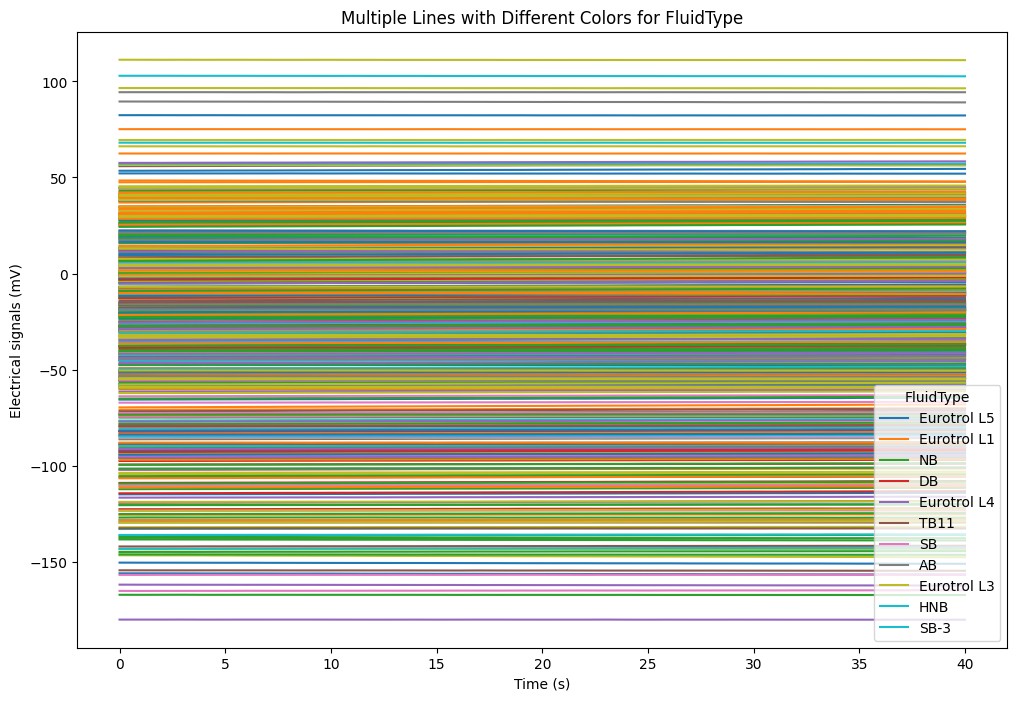

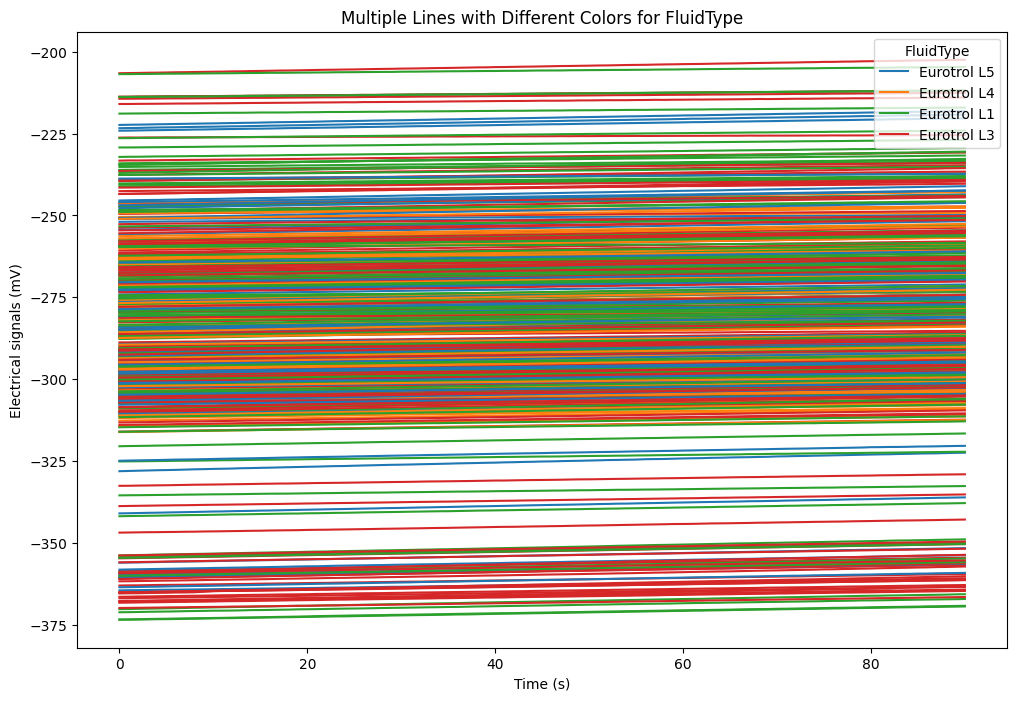

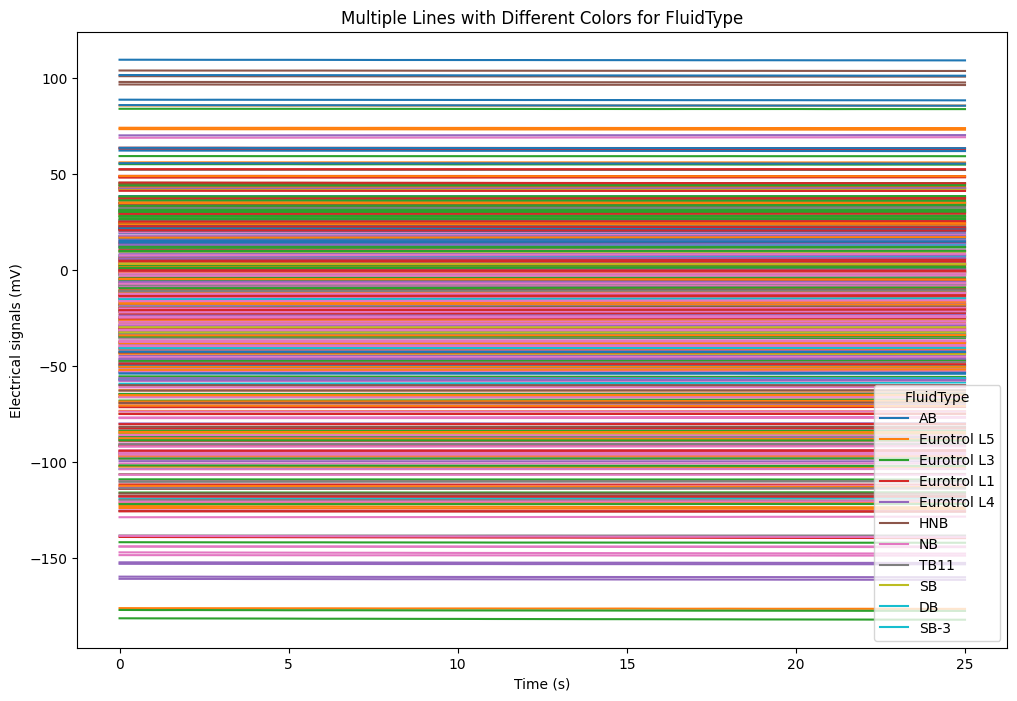

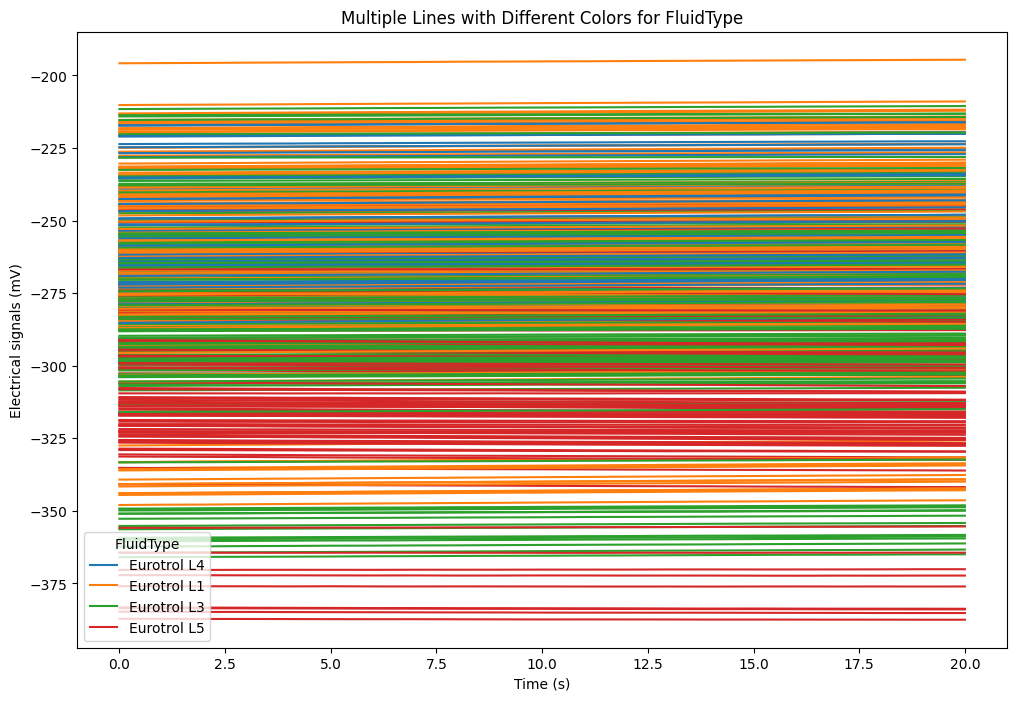

In [23]:
# Plot Fluid Type
plot_all_time_series_in_group(A1_cal_window_combine,"FluidType")
# plot_all_time_series_in_group(A2_cal_window_combine,"FluidType")
# plot_all_time_series_in_group(A1_blood_cal_window_combine,"FluidType")
# plot_all_time_series_in_group(A2_blood_cal_window_combine,"FluidType")
# plot_all_time_series_in_group(A1_aquous_cal_window_combine,"FluidType")
# plot_all_time_series_in_group(A2_aquous_cal_window_combine,"FluidType")

plot_all_time_series_in_group(B1_blood_cal_window_combine,"FluidType")
# plot_all_time_series_in_group(B2_blood_cal_window_combine,"FluidType")
# plot_all_time_series_in_group(B1_aquous_cal_window_combine,"FluidType")
# plot_all_time_series_in_group(B2_aquous_cal_window_combine,"FluidType")

# Plot Fluid Type
plot_all_time_series_in_group(A1_sample_window_combine,"FluidType")
# plot_all_time_series_in_group(A2_sample_window_combine,"FluidType")
# plot_all_time_series_in_group(A1_blood_sample_window_combine,"FluidType")
# plot_all_time_series_in_group(A2_blood_sample_window_combine,"FluidType")
# plot_all_time_series_in_group(A1_aquous_sample_window_combine,"FluidType")
# plot_all_time_series_in_group(A2_aquous_sample_window_combine,"FluidType")

plot_all_time_series_in_group(B1_blood_sample_window_combine,"FluidType")
# plot_all_time_series_in_group(B2_blood_sample_window_combine,"FluidType")
# plot_all_time_series_in_group(B1_aquous_sample_window_combine,"FluidType")
# plot_all_time_series_in_group(B2_aquous_sample_window_combine,"FluidType")

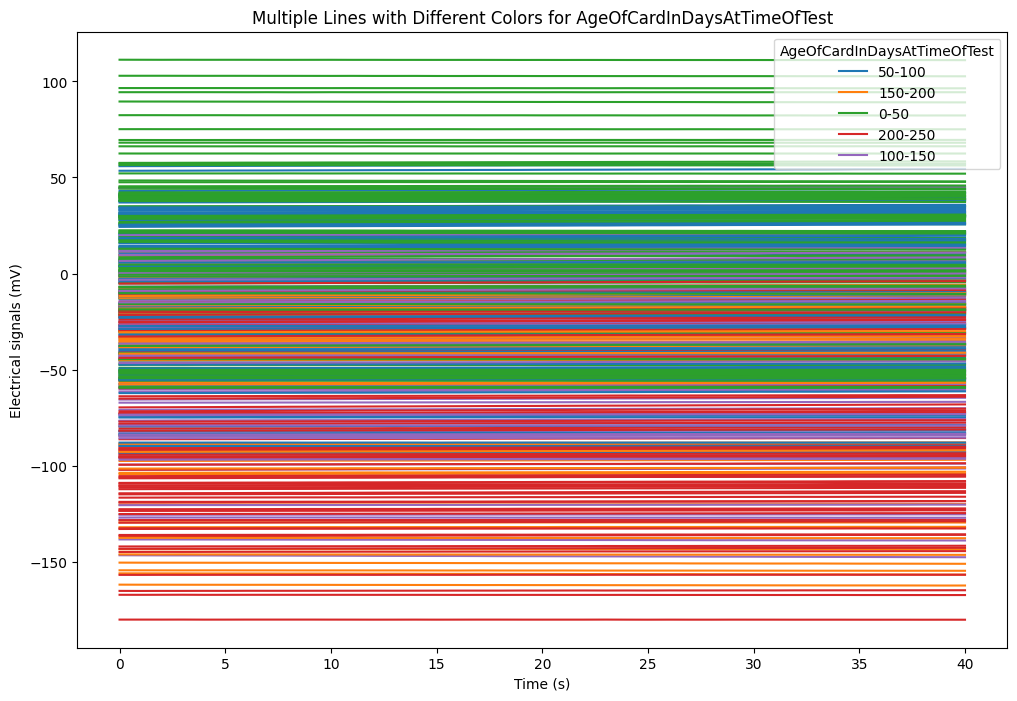

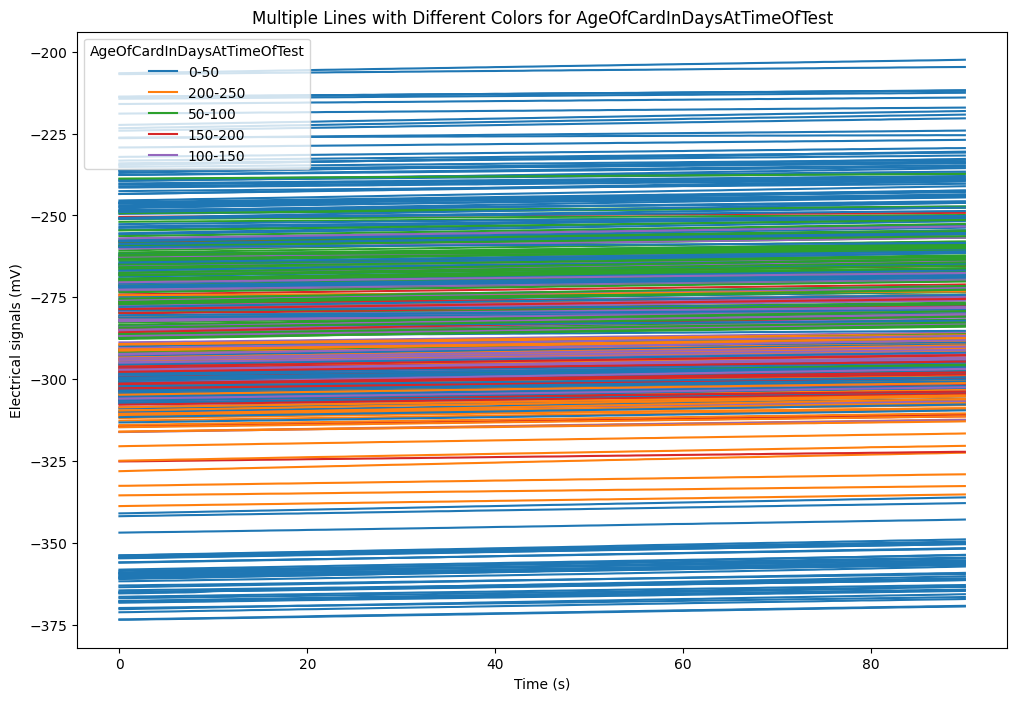

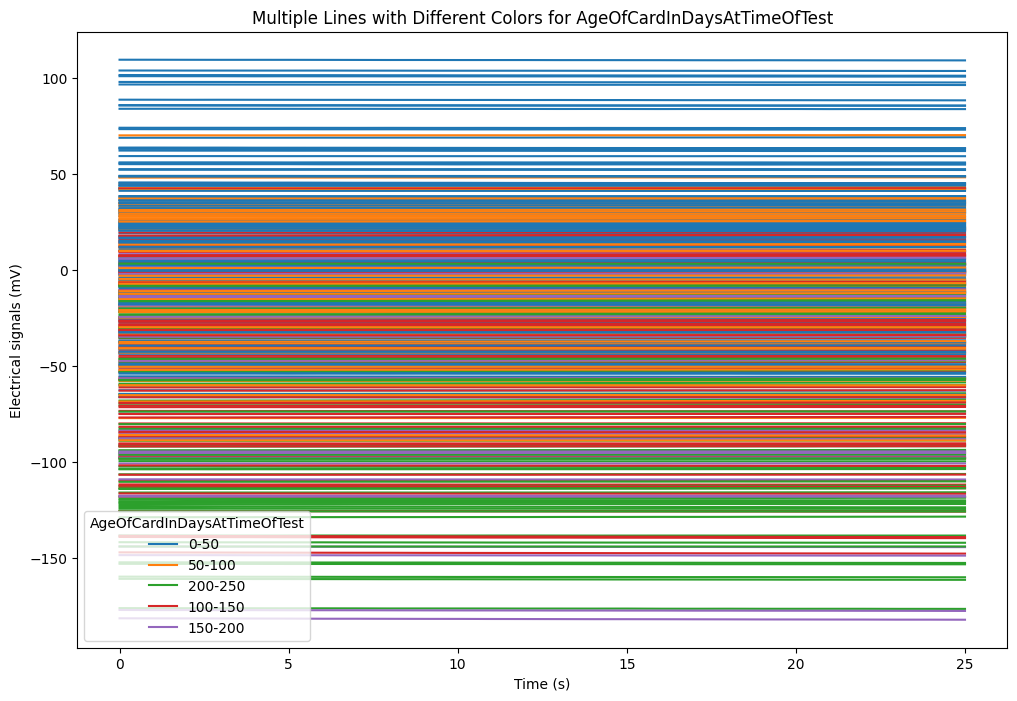

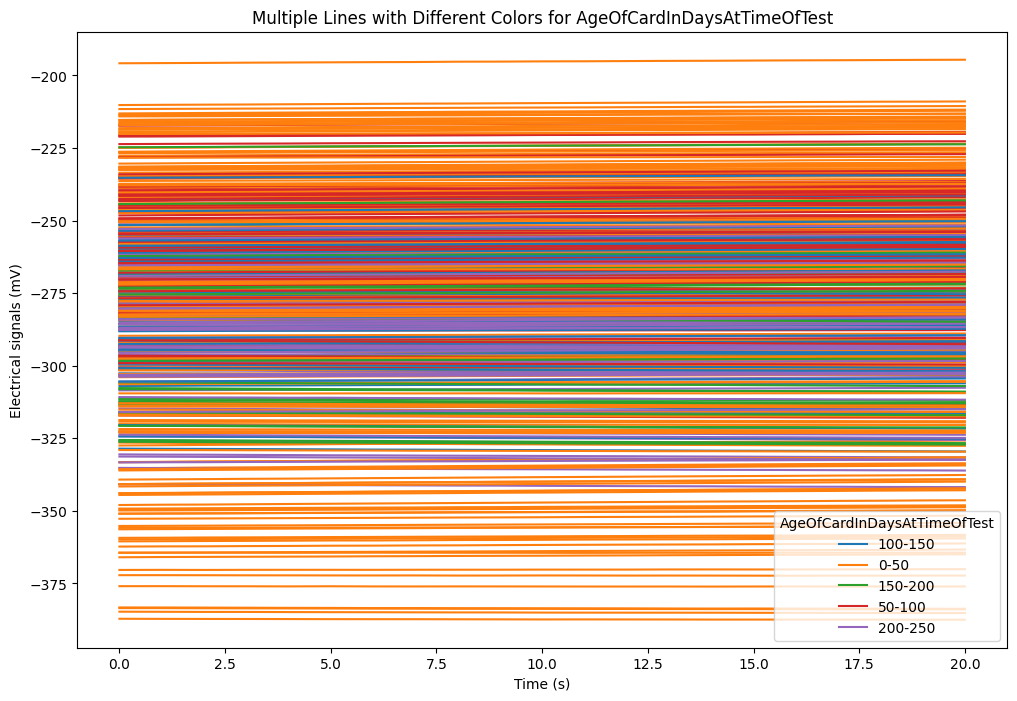

In [24]:
# Plot Card Age
plot_all_time_series_in_group(A1_cal_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(A2_cal_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(A1_blood_cal_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(A2_blood_cal_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(A1_aquous_cal_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(A2_aquous_cal_window_combine,"AgeOfCardInDaysAtTimeOfTest")

plot_all_time_series_in_group(B1_blood_cal_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(B2_blood_cal_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(B1_aquous_cal_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(B2_aquous_cal_window_combine,"AgeOfCardInDaysAtTimeOfTest")

# Plot Card Age
plot_all_time_series_in_group(A1_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(A2_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(A1_blood_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(A2_blood_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(A1_aquous_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(A2_aquous_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest")

plot_all_time_series_in_group(B1_blood_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(B2_blood_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(B1_aquous_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest")
# plot_all_time_series_in_group(B2_aquous_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest")

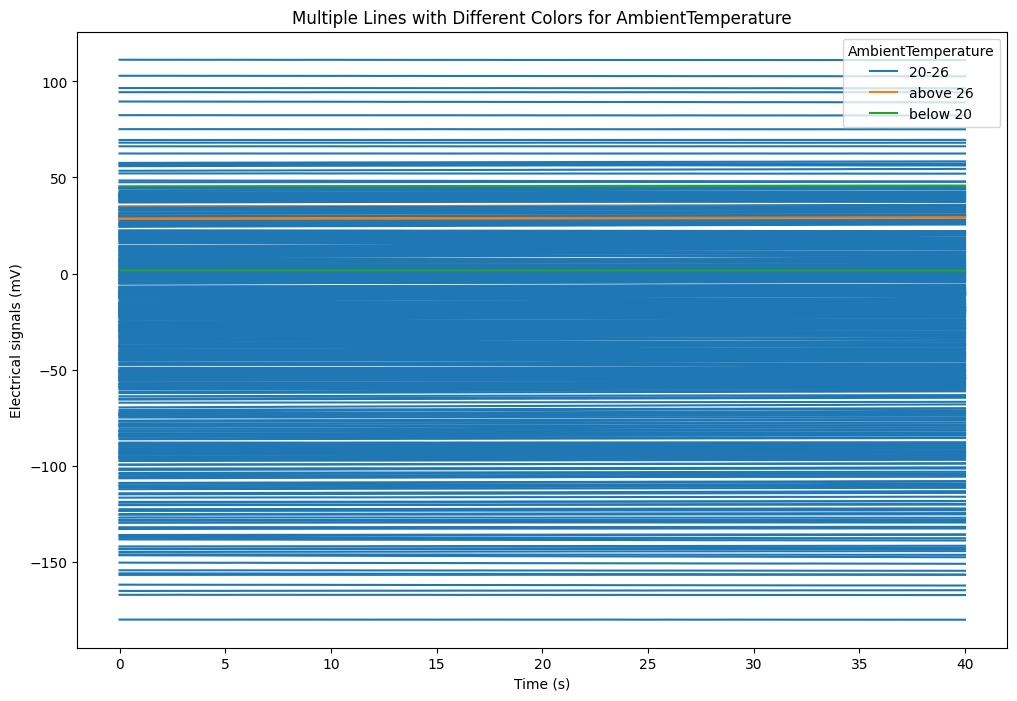

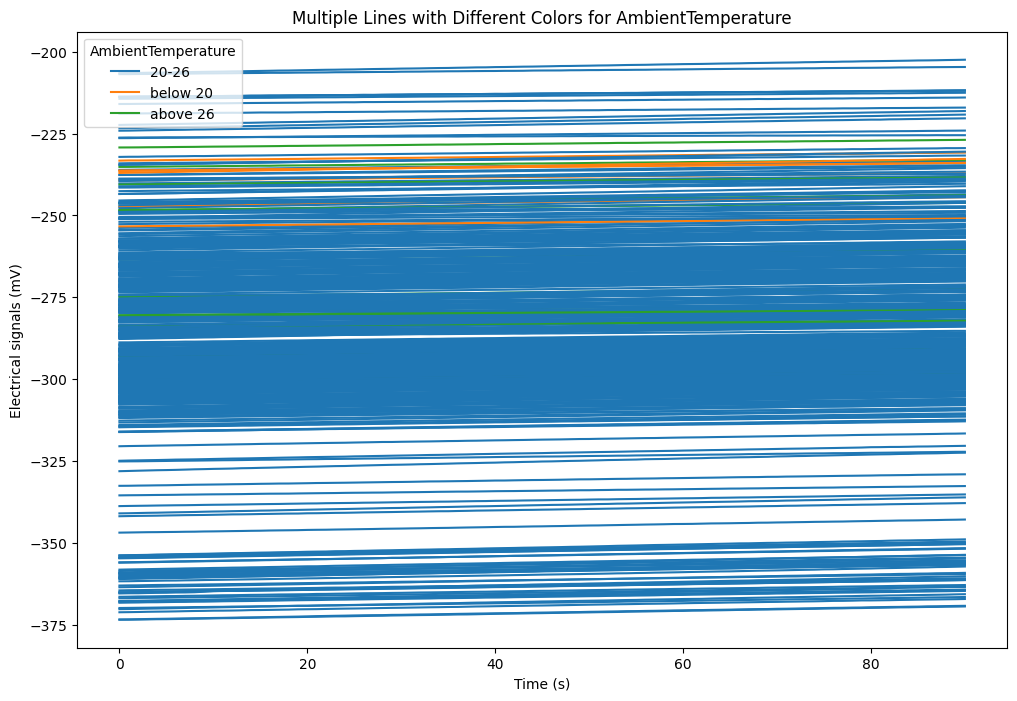

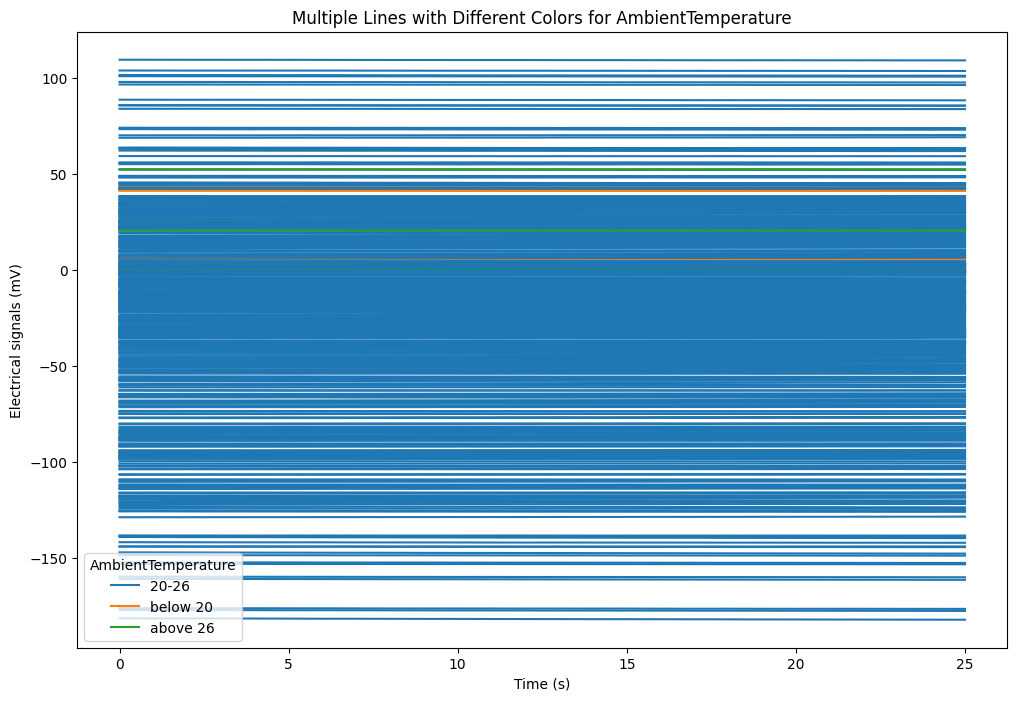

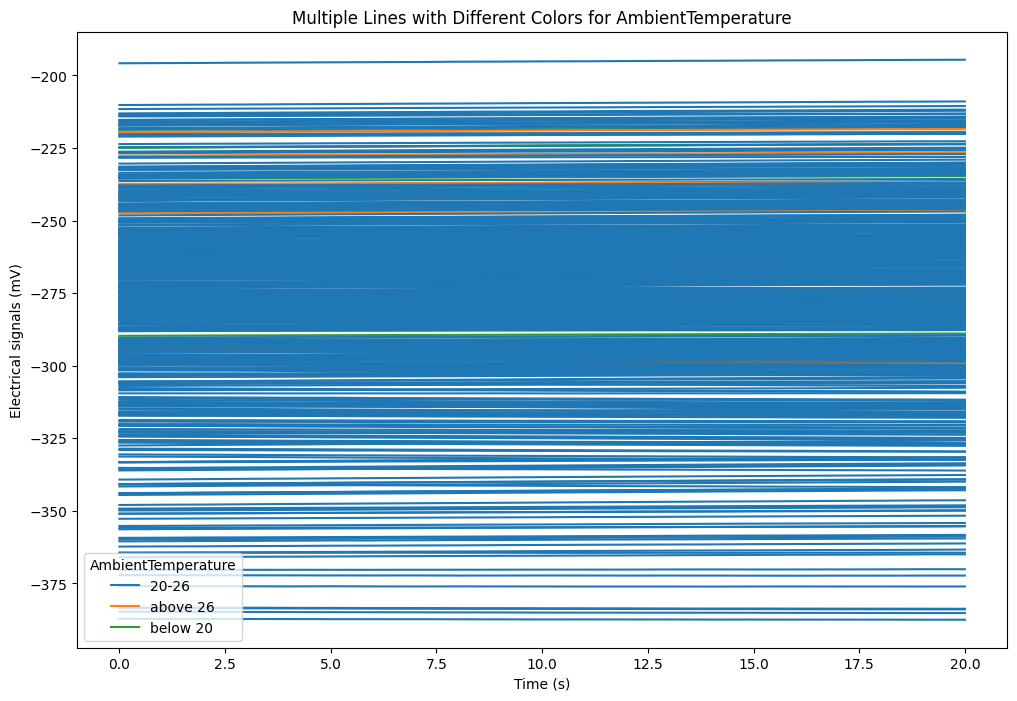

In [25]:
# Plot Temperature
plot_all_time_series_in_group(A1_cal_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(A2_cal_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(A1_blood_cal_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(A2_blood_cal_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(A1_aquous_cal_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(A2_aquous_cal_window_combine,"AmbientTemperature")

plot_all_time_series_in_group(B1_blood_cal_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(B2_blood_cal_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(B1_aquous_cal_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(B2_aquous_cal_window_combine,"AmbientTemperature")

# Plot Temperature
plot_all_time_series_in_group(A1_sample_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(A2_sample_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(A1_blood_sample_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(A2_blood_sample_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(A1_aquous_sample_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(A2_aquous_sample_window_combine,"AmbientTemperature")

plot_all_time_series_in_group(B1_blood_sample_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(B2_blood_sample_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(B1_aquous_sample_window_combine,"AmbientTemperature")
# plot_all_time_series_in_group(B2_aquous_sample_window_combine,"AmbientTemperature")

In [ ]:
def plot_all_time_series(df):
    plt.figure(figsize=(6, 4))

    for index, row in df.iterrows():
        plt.plot(row.values, label=f'Time Series {index + 1}')

    plt.ylabel('Electrical signals (mV)')
    plt.xlabel('Time (s)')

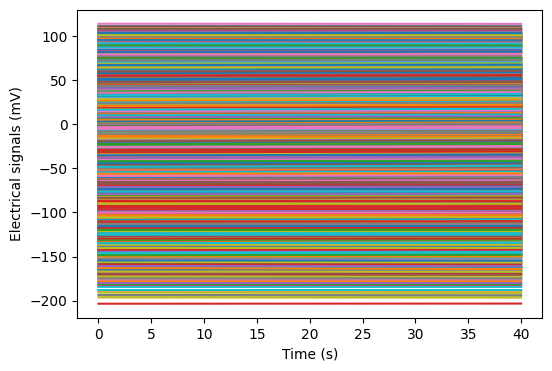

In [ ]:
plot_all_time_series(A1_cal_window)

## 10. PCA

1. Standardize the data
2. Visualize the standardize data
3. Apply PCA setting 2 PC's
4. Extract the Scores
5. Identify the Time Series which contribute most to each PC

Thanks to PCA's sensitivity, it can be used to detect outliers in multivariate datasets. Principal Component Analysis (PCA) is a widely used technique for dimensionality reduction while preserving relevant information. Due to its sensitivity, it can also be used to detect outliers in multivariate datasets.

https://s-ai-f.github.io/Time-Series/outlier-detection-in-time-series.html

In [ ]:
def perform_pca_analysis(data, title):
    # Step 1: Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Visualizing scale data
    data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)
    plot_all_time_series(data_scaled_df)
    plt.title(title)
    plt.show()

    # Step 2: Determine the number of components
    pca_full = PCA()
    pca_full.fit(data_scaled)
    print('Explained variance for each component:')
    print(pca_full.explained_variance_ratio_)

    # Step 3: Apply PCA on 2 components
    pca = PCA(n_components=2)
    pca_scores = pca.fit_transform(data_scaled)

    # Explain variance ratio
    print('\nExplain variance PC1 (%): ', pca.explained_variance_ratio_[0]*100)
    print('Explain variance PC2 (%): ', pca.explained_variance_ratio_[1]*100)

    # Loadings
    loadings = pca.components_
    loadings_df = pd.DataFrame(loadings.T, columns=['PC1_Loadings', 'PC2_Loadings'], index=[f'TimePoint_{i}' for i in range(data_scaled.shape[1])])
    print("\nLoadings:\n", loadings_df)

    # Scores
    scores_df = pd.DataFrame(pca_scores, columns=['PC1_Scores', 'PC2_Scores'], index=[f'TimeSeries_{data.index[i]}' for i in range(data_scaled.shape[0])])
    print("\nPC Scores:\n", scores_df)

    # Identify which time series contributes the most to each principal component
    max_contribution_index_pc1 = np.argmax(np.abs(pca_scores[:, 0]))
    max_contribution_index_pc2 = np.argmax(np.abs(pca_scores[:, 1]))
    print(f'\nThe time series contributing most to PC1 is at index {max_contribution_index_pc1} with TestID {data.index[max_contribution_index_pc1]}')
    print(f'The time series contributing most to PC2 is at index {max_contribution_index_pc2} with TestID {data.index[max_contribution_index_pc2]}')

    # PCA visualization
    plt.figure(figsize=(6, 4))
    plt.scatter(pca_scores[:, 0], pca_scores[:, 1], label='System 1')
    plt.title('PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

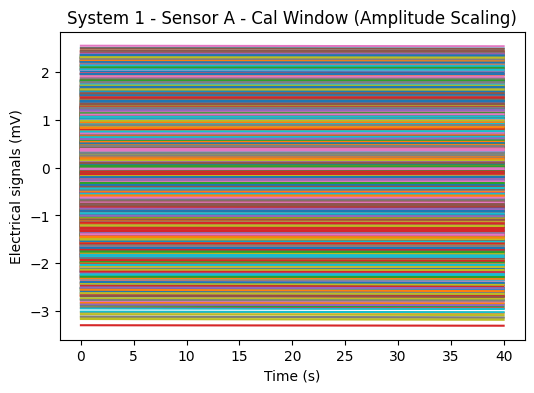

Explained variance for each component:
[9.99989640e-01 1.03240259e-05 2.53585878e-09 1.46176144e-09
 1.19641970e-09 1.11223588e-09 1.07884893e-09 1.04469926e-09
 1.01399563e-09 1.00197716e-09 9.79934006e-10 9.52342398e-10
 9.42709044e-10 9.33002932e-10 9.23663022e-10 9.18679583e-10
 9.00150266e-10 8.87693876e-10 8.81770130e-10 8.76580061e-10
 8.64427245e-10 8.53283835e-10 8.33819720e-10 8.31419786e-10
 8.18389160e-10 8.17900559e-10 7.99371459e-10 7.88936160e-10
 7.81148845e-10 7.77458211e-10 7.71216479e-10 7.63507241e-10
 7.56125785e-10 7.48570354e-10 7.36251669e-10 7.27487564e-10
 7.17565029e-10 7.12864963e-10 7.00863498e-10 6.99615472e-10
 6.81679039e-10]

Explain variance PC1 (%):  99.99896401498857
Explain variance PC2 (%):  0.0010324025890230642

Loadings:
               PC1_Loadings  PC2_Loadings
TimePoint_0      -0.156172      0.266146
TimePoint_1      -0.156172      0.252600
TimePoint_2      -0.156173      0.238938
TimePoint_3      -0.156173      0.225551
TimePoint_4      -0.15

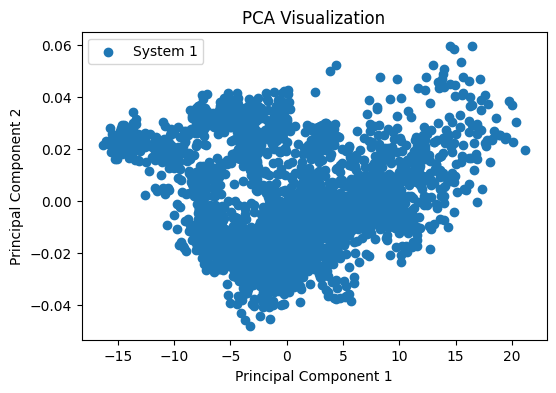

In [ ]:
perform_pca_analysis(A1_cal_window, 'System 1 - Sensor A - Cal Window (Amplitude Scaling)')

## 11. Functional PCA

In [26]:
pip install scikit-fda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 12.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.8 MB/s eta 0:00:00
  Created wheel for fdasrsf: filename=fdasrsf-2.5.10-cp310-cp310-linux_x86_64.whl size=3081574 sha256=ff52819ccdd1cbf4b195ac5db2ce8c088866c899d8ac45524c55cdde03134841
  Stored in directory: /root/.cache/pip/wheels/e8/52/1c/c4c363a070fc6643f741e1e7ecaae39377bc19130052054270
Successfully built fdasrsf


In [36]:
import numpy as np
import pandas as pd
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA

def perform_functional_pca(data_matrix, title):
    # Convert the data matrix to an FDataGrid object
    fd = FDataGrid(data_matrix=data_matrix, grid_points=data_matrix.columns.astype(float))

    # Apply Functional PCA
    fpca = FPCA(n_components=2)
    fpca.fit(fd)

    pc_scores = fpca.transform(fd)

    # Explain variance ratio
    print('Explain variance PC1 (%): ', fpca.explained_variance_ratio_[0] * 100)
    print('Explain variance PC2 (%): ', fpca.explained_variance_ratio_[1] * 100)

    # --- Loadings ---
    # Extract the principal components (loadings)
    principal_components = fpca.components_

    # --- Scores ---
    # Print the scores to see contributions of each time series to each principal component
    pc_scores_df = pd.DataFrame(pc_scores, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[f'TimeSeries_{data_matrix.index[i]}' for i in range(data_matrix.shape[0])])
    print("PC Scores:\n", pc_scores_df)

    # Identify which time series (functional data object) contributes the most to each principal component
    max_contribution_index_pc1 = np.argmax(np.abs(pc_scores[:, 0]))  # Index of the maximum absolute score in the first PC
    max_contribution_index_pc2 = np.argmax(np.abs(pc_scores[:, 1]))  # Index of the maximum absolute score in the second PC

    print(f'The time series contributing most to PC1 is at index {max_contribution_index_pc1} with TestID {data_matrix.index[max_contribution_index_pc1]}')
    print(f'The time series contributing most to PC2 is at index {max_contribution_index_pc2} with TestID {data_matrix.index[max_contribution_index_pc2]}')

    # --- PCA visualization ---
    fpca.components_.plot()
    plt.title(title)
    plt.legend(['Component 1', 'Component 2'])
    #plt.figure(figsize=(4, 4))
    plt.show()
    fpca.components_[0].plot()
    plt.title(title)
    plt.legend(['Component 1'])
    plt.show()
    fpca.components_[1].plot()
    plt.title(title)
    plt.legend(['Component 2'])
    plt.show()
    #return [data_matrix.index[max_contribution_index_pc1], data_matrix.index[max_contribution_index_pc1]]

<ipython-input-36-9aeb0727abd3>:4: DeprecationWarning: The module "projection" is deprecated. Please use "dim_reduction"
  from skfda.preprocessing.dim_reduction.projection import FPCA


FPCA CALIBRATION WINDOW

A1_cal_window
Explain variance PC1 (%):  99.99901313297069
Explain variance PC2 (%):  0.0009833238630759771
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -511.928238    0.953037
TimeSeries_12414201 -431.878434    0.321238
TimeSeries_12414202 -527.954625    0.837068
TimeSeries_12414203 -512.974359    0.772892
TimeSeries_12414204 -569.118691    0.931376
...                         ...         ...
TimeSeries_12537663 -208.148755   -1.509049
TimeSeries_12539049  -34.663259   -0.605466
TimeSeries_12572832  480.243758    1.049674
TimeSeries_12572836 -104.517339   -0.169876
TimeSeries_12622570  904.125936    1.548010

[3349 rows x 2 columns]
The time series contributing most to PC1 is at index 2683 with TestID 12573667
The time series contributing most to PC2 is at index 1784 with TestID 12529762


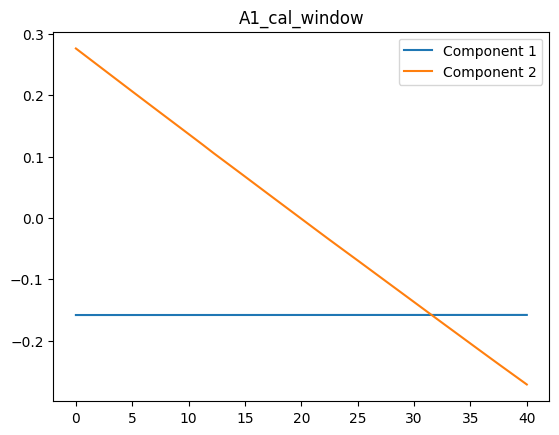

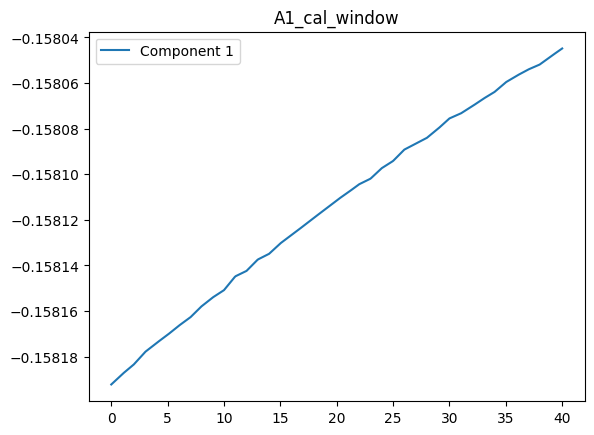

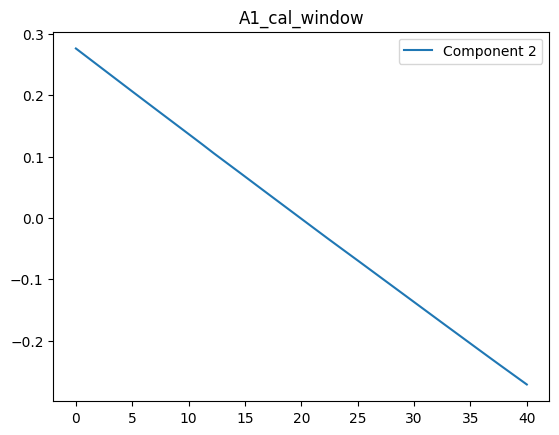

A2_cal_window
Explain variance PC1 (%):  99.99896719079081
Explain variance PC2 (%):  0.0010313889820635278
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -235.811528    0.952921
TimeSeries_3551012 -160.076481    1.060921
TimeSeries_3551031 -318.448001    1.483052
TimeSeries_3551047 -241.241502    0.929191
TimeSeries_3551065 -226.000292    1.093668
...                        ...         ...
TimeSeries_3518461  -32.332739    1.135309
TimeSeries_3518462  136.716909    1.716601
TimeSeries_3518621  174.316532    1.346695
TimeSeries_3518680 -420.002186    1.615260
TimeSeries_3518682  -90.097550    1.878944

[7535 rows x 2 columns]
The time series contributing most to PC1 is at index 5354 with TestID 3556087
The time series contributing most to PC2 is at index 6844 with TestID 3567819


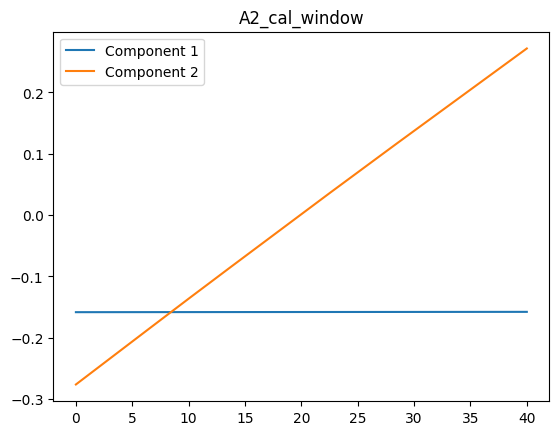

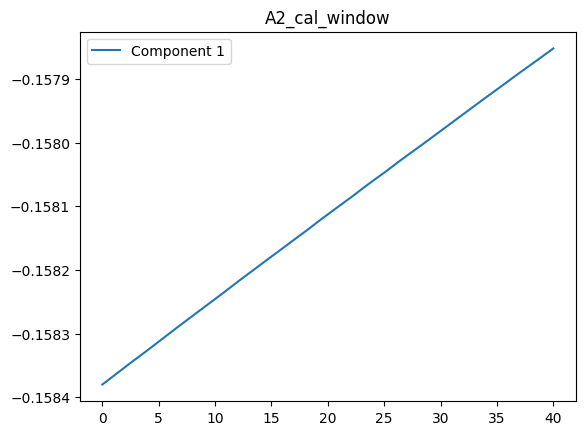

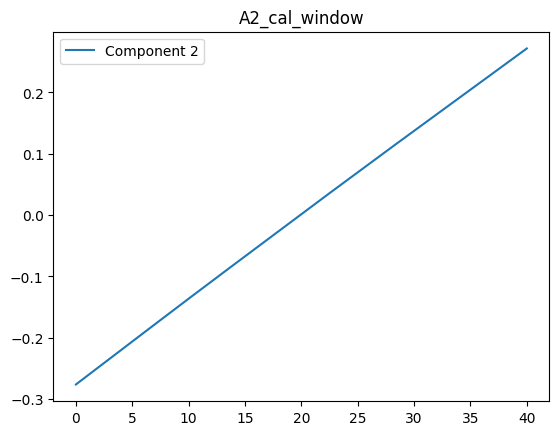

A1_blood_cal_window
Explain variance PC1 (%):  99.99898050747007
Explain variance PC2 (%):  0.0010158898515333643
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -466.060746    0.785260
TimeSeries_12414201 -386.010834    0.167402
TimeSeries_12414202 -482.087113    0.666505
TimeSeries_12414203 -467.106836    0.604938
TimeSeries_12414204 -523.251195    0.753668
...                         ...         ...
TimeSeries_12624891  -77.039267   -0.373435
TimeSeries_12624893 -110.343970   -0.341533
TimeSeries_12537663 -162.280840   -1.623983
TimeSeries_12572832  526.111217    1.054466
TimeSeries_12572836  -58.649659   -0.266792

[1916 rows x 2 columns]
The time series contributing most to PC1 is at index 1803 with TestID 12572826
The time series contributing most to PC2 is at index 1882 with TestID 12599845


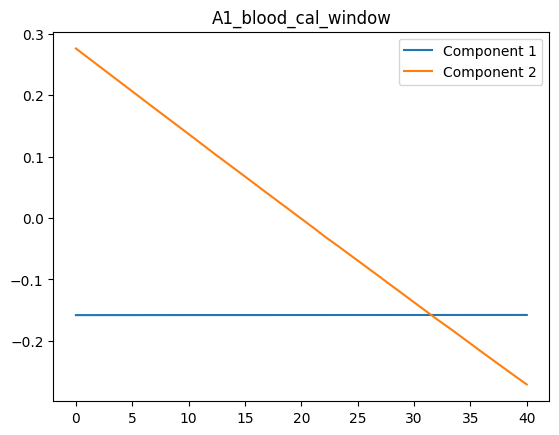

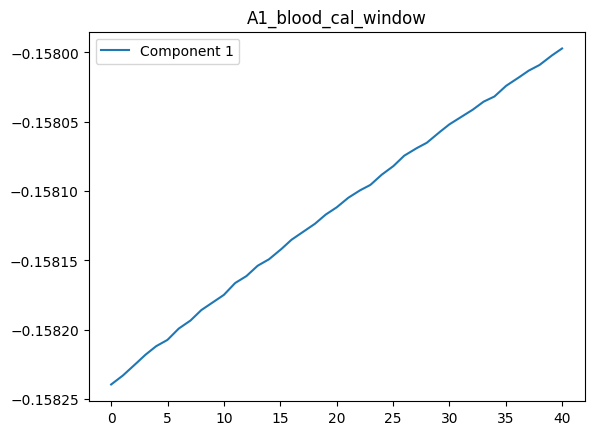

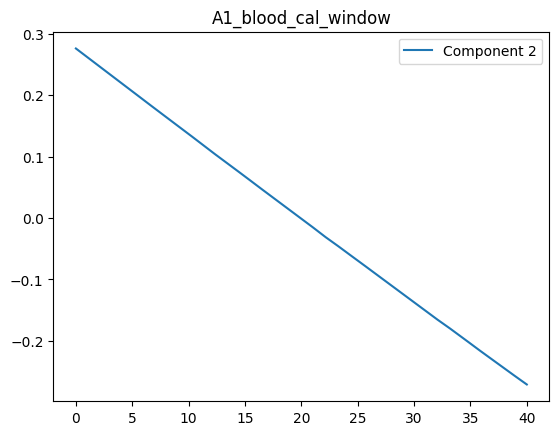

A2_blood_cal_window
Explain variance PC1 (%):  99.99891324250726
Explain variance PC2 (%):  0.0010852452966890512
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -208.597245   -1.068516
TimeSeries_3551012 -132.862194   -1.174030
TimeSeries_3551031 -291.233701   -1.601344
TimeSeries_3551047 -214.027219   -1.044957
TimeSeries_3551065 -198.786004   -1.208934
...                        ...         ...
TimeSeries_3518459 -422.986546   -0.589278
TimeSeries_3518460 -448.803156   -1.729648
TimeSeries_3518431  -95.234287   -1.572003
TimeSeries_3518461   -5.118450   -1.244237
TimeSeries_3518462  163.931217   -1.820001

[4724 rows x 2 columns]
The time series contributing most to PC1 is at index 3619 with TestID 3556087
The time series contributing most to PC2 is at index 3069 with TestID 3561214


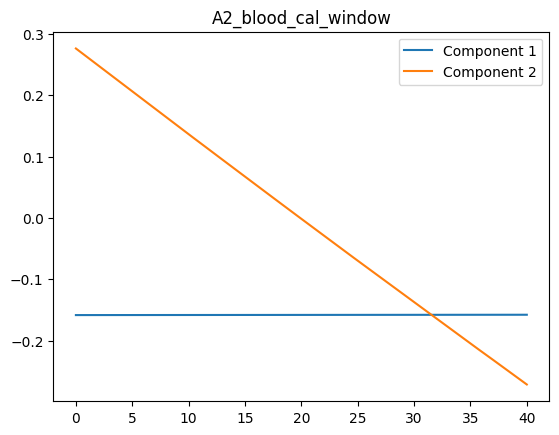

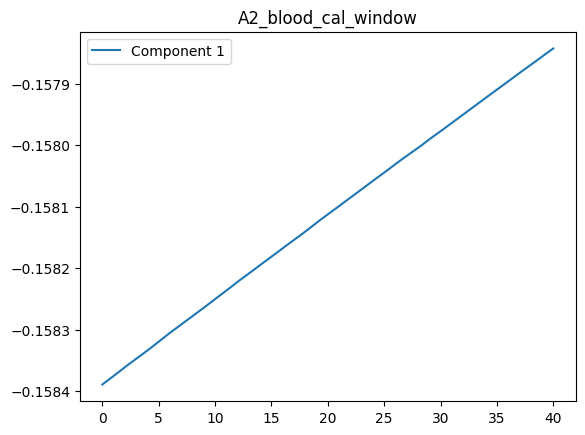

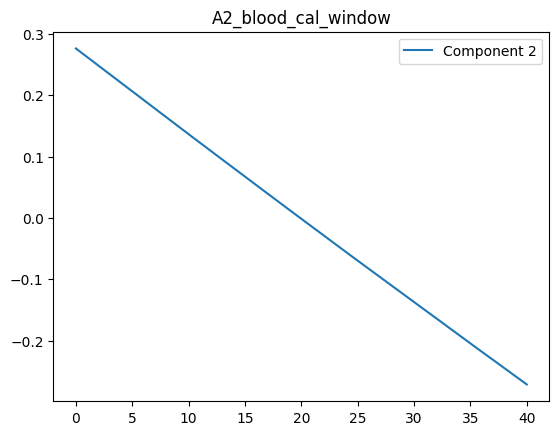

A1_aquous_cal_window
Explain variance PC1 (%):  99.99903631073354
Explain variance PC2 (%):  0.0009600297561910603
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372 -629.834138    1.125510
TimeSeries_12414373 -595.400743    1.159224
TimeSeries_12414374 -621.052115    1.234430
TimeSeries_12414375 -596.268795    1.117465
TimeSeries_12414377 -647.688876    1.506192
...                         ...         ...
TimeSeries_12470355  438.399068    1.051695
TimeSeries_12470361  543.245842    0.948795
TimeSeries_12470365  -16.820129   -0.712827
TimeSeries_12539049  -95.990977   -0.456802
TimeSeries_12622570  842.798898    1.376544

[1433 rows x 2 columns]
The time series contributing most to PC1 is at index 1042 with TestID 12573667
The time series contributing most to PC2 is at index 828 with TestID 12598120


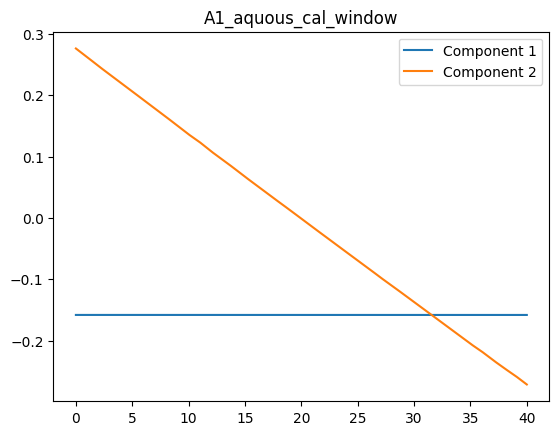

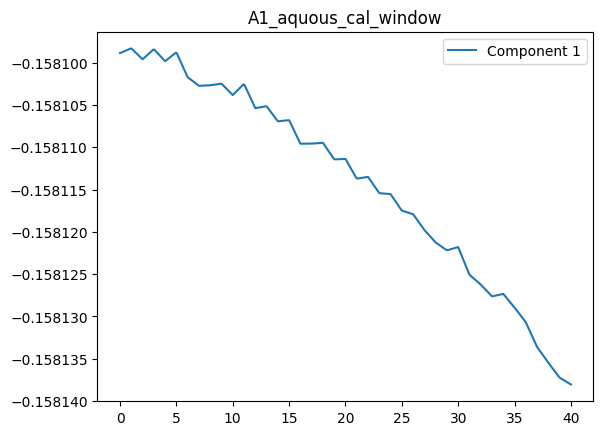

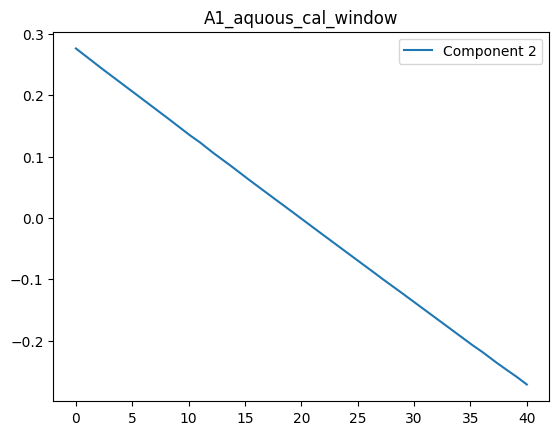

A2_aquous_cal_window
Explain variance PC1 (%):  99.99906167648676
Explain variance PC2 (%):  0.0009370164270387054
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083 -665.977111   -0.623435
TimeSeries_3545084 -619.005020   -0.677462
TimeSeries_3545085 -508.275839   -0.958243
TimeSeries_3545086 -578.971979   -0.604525
TimeSeries_3545087 -537.851578   -0.625387
...                        ...         ...
TimeSeries_3518708 -522.267253    0.690908
TimeSeries_3518710  -14.594300    2.107727
TimeSeries_3518621  128.581721    1.181280
TimeSeries_3518680 -465.737029    1.369587
TimeSeries_3518682 -135.832431    1.677817

[2811 rows x 2 columns]
The time series contributing most to PC1 is at index 2133 with TestID 3572300
The time series contributing most to PC2 is at index 2424 with TestID 3567819


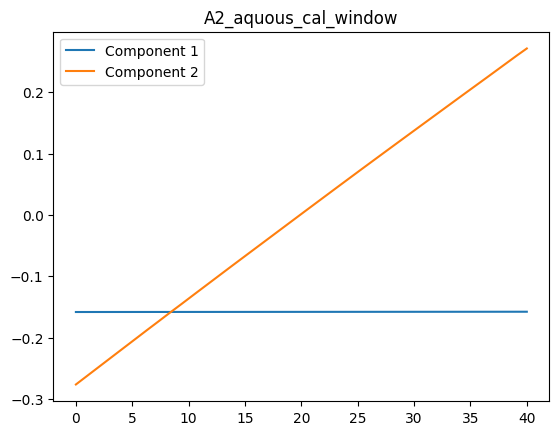

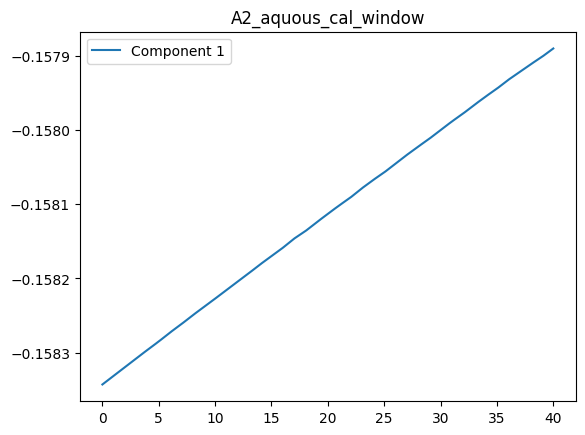

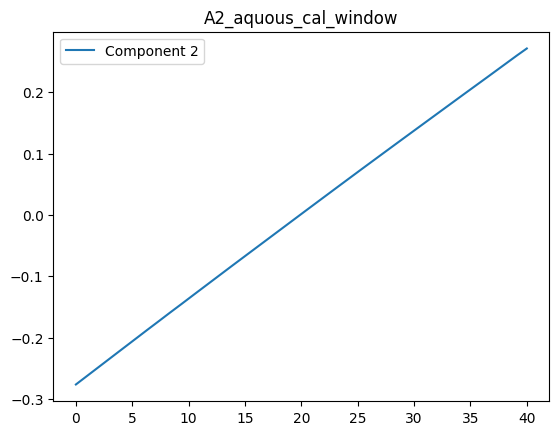

B1_blood_cal_window
Explain variance PC1 (%):  99.99429965213389
Explain variance PC2 (%):  0.005674922119799848
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -280.735614    3.616149
TimeSeries_12414201 -273.224911    3.950660
TimeSeries_12414202 -290.152444    3.608065
TimeSeries_12414203 -307.783676    3.319943
TimeSeries_12414204 -354.889295    3.775659
...                         ...         ...
TimeSeries_12537664 -246.348852    2.054196
TimeSeries_12537668 -172.027863    0.162744
TimeSeries_12624891  119.129034   -2.287491
TimeSeries_12624893   39.841893   -2.576547
TimeSeries_12537663 -137.189694    0.334835

[1944 rows x 2 columns]
The time series contributing most to PC1 is at index 219 with TestID 12544066
The time series contributing most to PC2 is at index 1681 with TestID 12395731


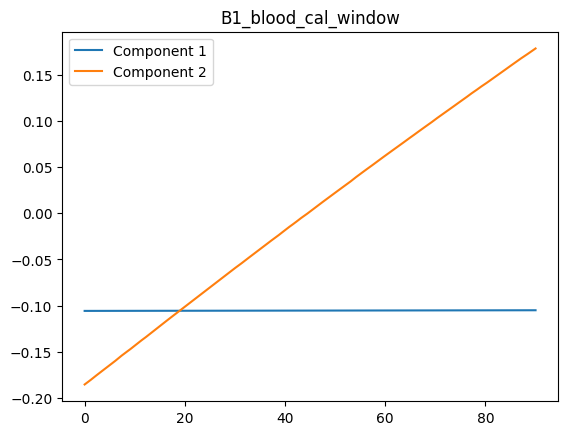

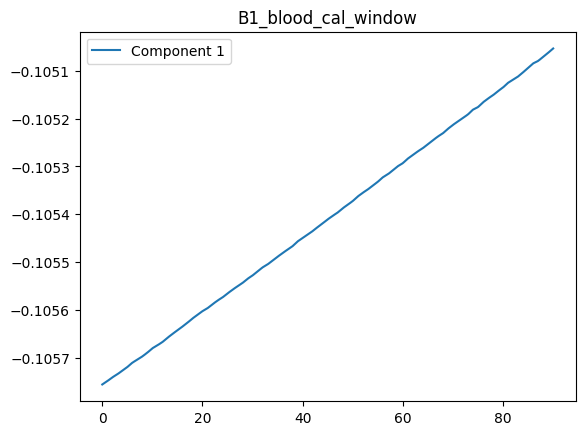

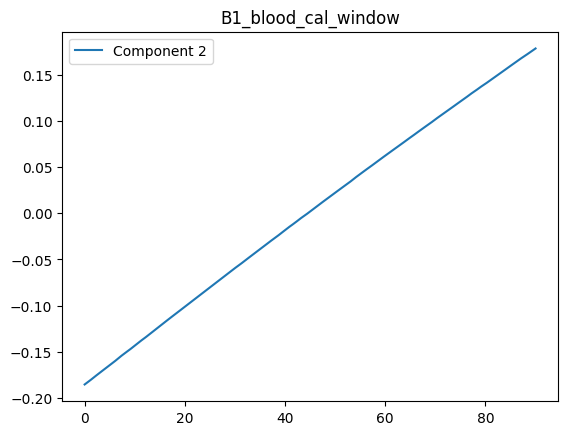

B2_blood_cal_window
Explain variance PC1 (%):  99.9954154050913
Explain variance PC2 (%):  0.004567289166225345
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995  107.739368    0.463722
TimeSeries_3551012   10.189149   -0.872549
TimeSeries_3551031  315.567684   -0.174101
TimeSeries_3551047  189.279095    1.082127
TimeSeries_3551065  104.327362    0.521352
...                        ...         ...
TimeSeries_3518442  585.567207   -5.789235
TimeSeries_3518443  331.635655   -6.783318
TimeSeries_3518444  422.866251   -6.959739
TimeSeries_3518445  254.501070   -6.843832
TimeSeries_3518456  634.603988   -5.829742

[4893 rows x 2 columns]
The time series contributing most to PC1 is at index 418 with TestID 3556268
The time series contributing most to PC2 is at index 2526 with TestID 3567091


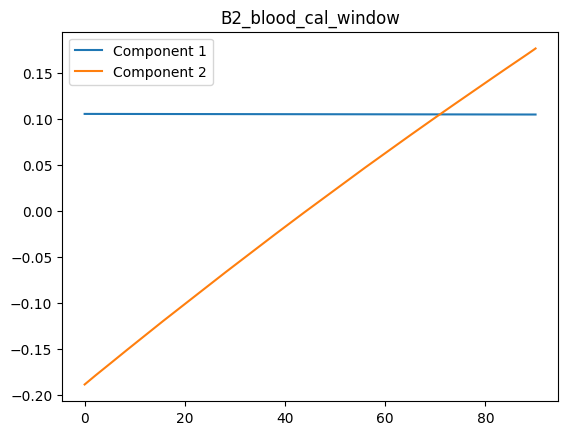

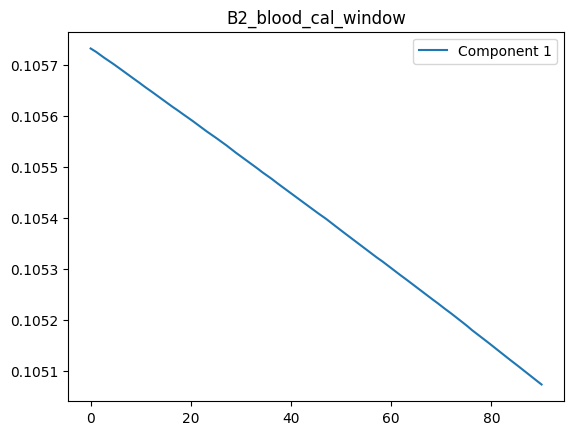

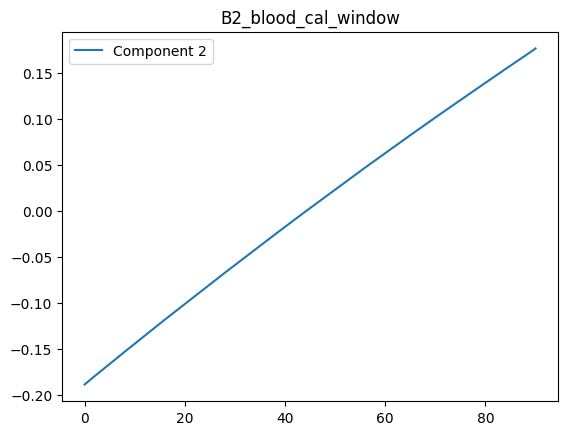

B1_aquous_cal_window
Explain variance PC1 (%):  99.99402628874078
Explain variance PC2 (%):  0.005943245121920721
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372  370.691377    2.814008
TimeSeries_12414373  373.625801    2.822501
TimeSeries_12414374  407.810233    3.268249
TimeSeries_12414375  405.188164    3.143201
TimeSeries_12414377  365.695460    2.549781
...                         ...         ...
TimeSeries_12470355 -117.699988   -3.399520
TimeSeries_12470361   60.284807   -1.418356
TimeSeries_12470365  125.647578   -0.829341
TimeSeries_12539049  129.244533   -1.050934
TimeSeries_12622570   -7.563354   -1.747086

[1431 rows x 2 columns]
The time series contributing most to PC1 is at index 472 with TestID 12437598
The time series contributing most to PC2 is at index 203 with TestID 12615993


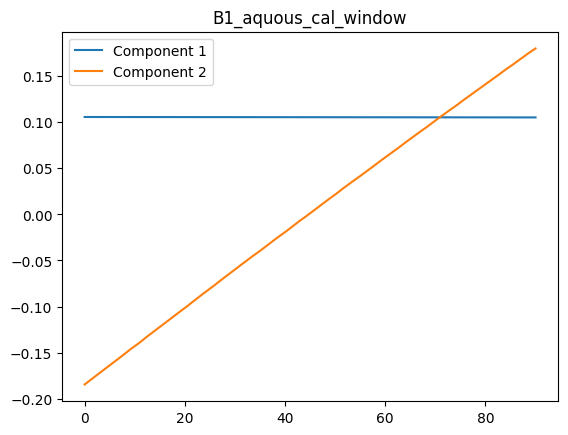

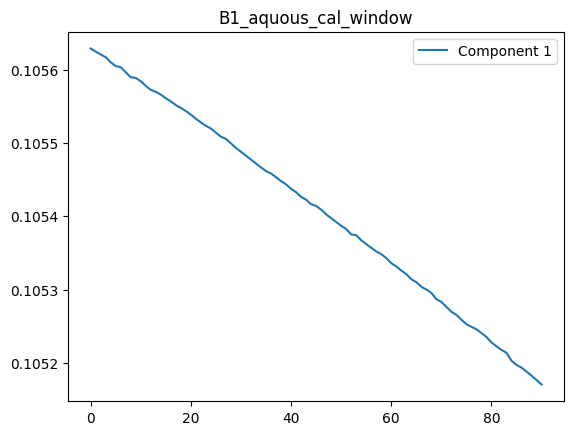

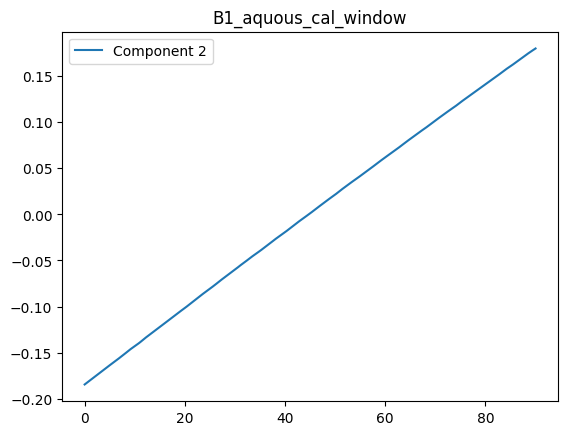

B2_aquous_cal_window
Explain variance PC1 (%):  99.99374509609679
Explain variance PC2 (%):  0.006235825869662634
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083  542.405894    3.544643
TimeSeries_3545084  531.495469    3.188401
TimeSeries_3545085  458.332247    2.269276
TimeSeries_3545086  544.628557    3.788931
TimeSeries_3545087  455.449713    3.318268
...                        ...         ...
TimeSeries_3518583  578.831070   -6.471654
TimeSeries_3518675  603.310206   -6.095167
TimeSeries_3518676  425.468952   -5.943599
TimeSeries_3518677  412.730241   -7.148036
TimeSeries_3518678  311.542760   -7.127060

[2852 rows x 2 columns]
The time series contributing most to PC1 is at index 195 with TestID 3548448
The time series contributing most to PC2 is at index 2426 with TestID 3567819


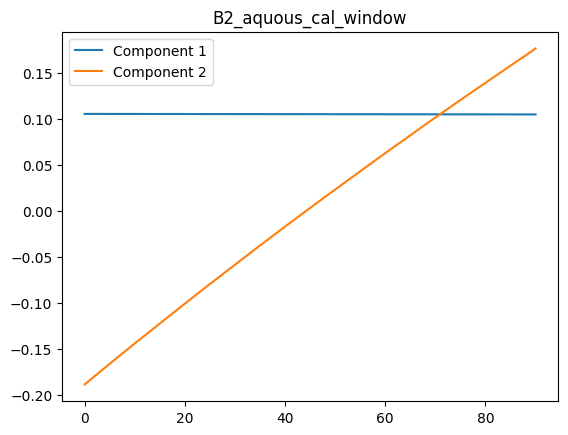

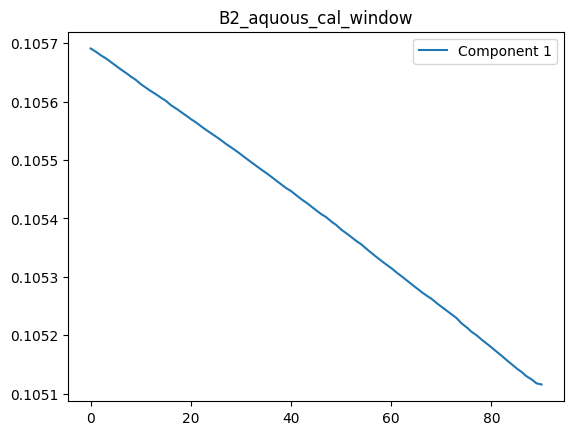

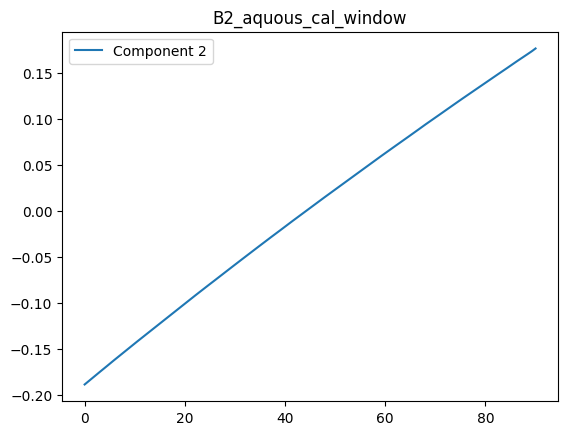

In [ ]:
print("FPCA CALIBRATION WINDOW\n")
print("A1_cal_window")
perform_functional_pca(A1_cal_window, "A1_cal_window")
print("A2_cal_window")
perform_functional_pca(A2_cal_window, "A2_cal_window")
print("A1_blood_cal_window")
perform_functional_pca(A1_blood_cal_window, "A1_blood_cal_window")
print("A2_blood_cal_window")
perform_functional_pca(A2_blood_cal_window, "A2_blood_cal_window")
print("A1_aquous_cal_window")
perform_functional_pca(A1_aquous_cal_window, "A1_aquous_cal_window")
print("A2_aquous_cal_window")
perform_functional_pca(A2_aquous_cal_window, "A2_aquous_cal_window")
print("B1_blood_cal_window")
perform_functional_pca(B1_blood_cal_window, "B1_blood_cal_window")
print("B2_blood_cal_window")
perform_functional_pca(B2_blood_cal_window, "B2_blood_cal_window")
print("B1_aquous_cal_window")
perform_functional_pca(B1_aquous_cal_window, "B1_aquous_cal_window")
print("B2_aquous_cal_window")
perform_functional_pca(B2_aquous_cal_window, "B2_aquous_cal_window")

FPCA SAMPLE WINDOW

A1_sample_window
Explain variance PC1 (%):  99.99970783589137
Explain variance PC2 (%):  0.0002886527385106802
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -364.644442   -0.282879
TimeSeries_12414201 -305.935026    0.005195
TimeSeries_12414202 -378.521086   -0.268362
TimeSeries_12414203 -366.840610   -0.229242
TimeSeries_12414204 -410.357556   -0.255063
...                         ...         ...
TimeSeries_12537663 -244.642467    0.395610
TimeSeries_12539049  -40.319011    0.308792
TimeSeries_12572832  311.002110   -0.296540
TimeSeries_12572836 -156.238221   -0.178490
TimeSeries_12622570  713.662600   -0.554970

[3349 rows x 2 columns]
The time series contributing most to PC1 is at index 2818 with TestID 12574513
The time series contributing most to PC2 is at index 531 with TestID 12615995


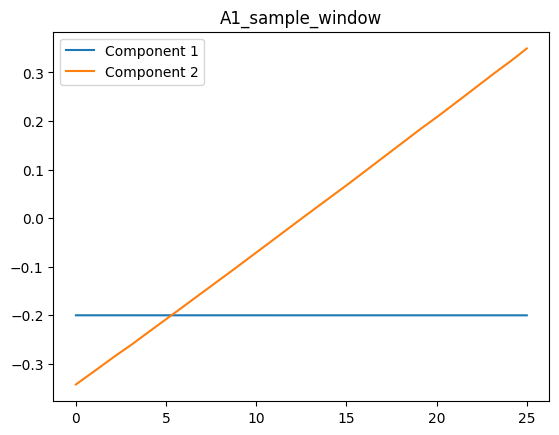

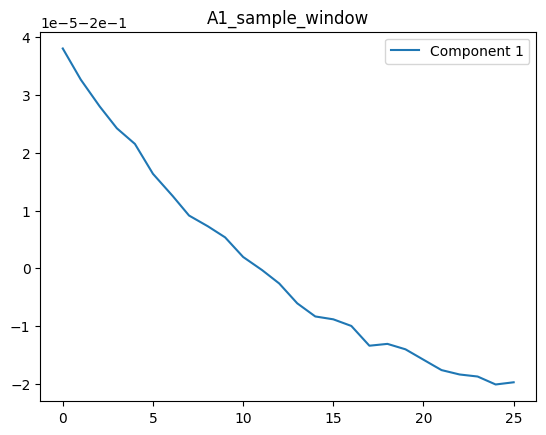

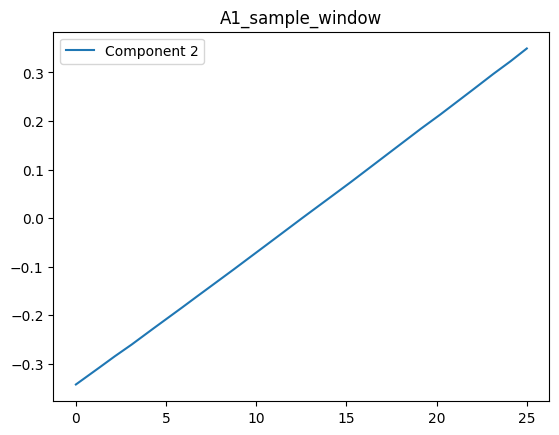

A2_sample_window
Explain variance PC1 (%):  99.99965471474869
Explain variance PC2 (%):  0.00034384565774712886
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -220.755540   -0.359323
TimeSeries_3551012 -162.149805   -0.390913
TimeSeries_3551031 -290.496379   -0.634445
TimeSeries_3551047 -225.124550   -0.378765
TimeSeries_3551065 -214.555525   -0.447031
...                        ...         ...
TimeSeries_3518461   37.409560   -0.404645
TimeSeries_3518462  165.836506   -0.329064
TimeSeries_3518621  112.185429   -0.608804
TimeSeries_3518680 -358.620202   -0.839022
TimeSeries_3518682  -98.790300   -0.881148

[7535 rows x 2 columns]
The time series contributing most to PC1 is at index 5354 with TestID 3556087
The time series contributing most to PC2 is at index 4259 with TestID 3561214


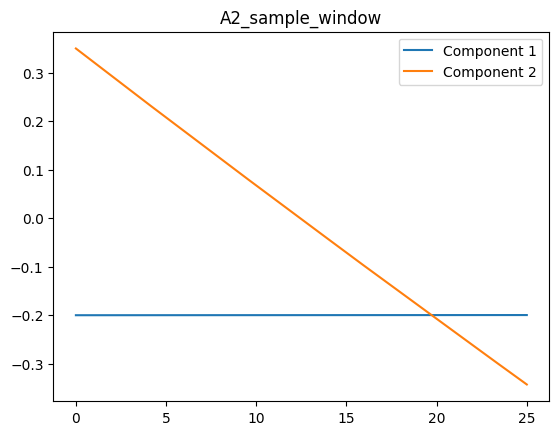

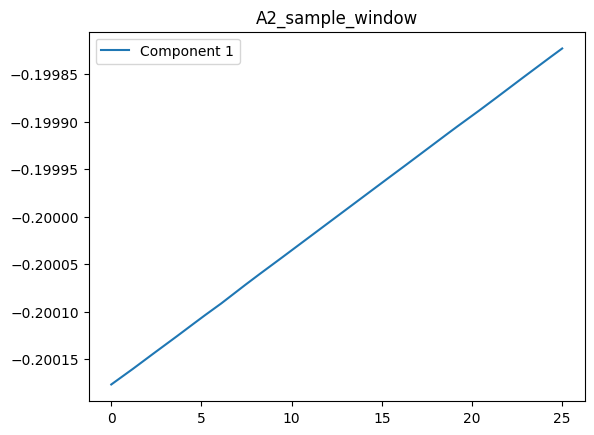

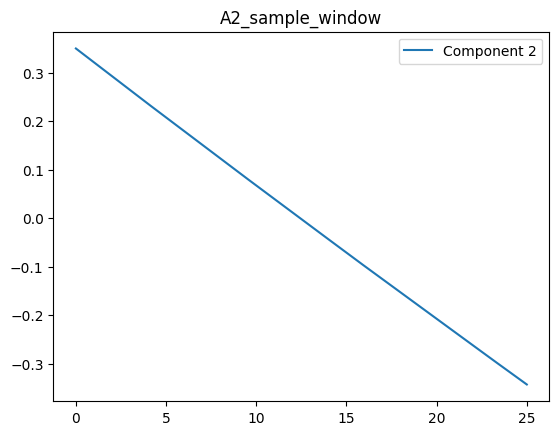

A1_blood_sample_window
Explain variance PC1 (%):  99.99973871958913
Explain variance PC2 (%):  0.0002574785190827343
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -334.869383    0.207780
TimeSeries_12414201 -276.159965   -0.080020
TimeSeries_12414202 -348.746026    0.193182
TimeSeries_12414203 -337.065550    0.154141
TimeSeries_12414204 -380.582496    0.179719
...                         ...         ...
TimeSeries_12624891   -1.555595   -0.135160
TimeSeries_12624893  -23.710333   -0.174037
TimeSeries_12537663 -214.867404   -0.470137
TimeSeries_12572832  340.777170    0.224526
TimeSeries_12572836 -126.463161    0.104302

[1916 rows x 2 columns]
The time series contributing most to PC1 is at index 1706 with TestID 12574513
The time series contributing most to PC2 is at index 462 with TestID 12191350


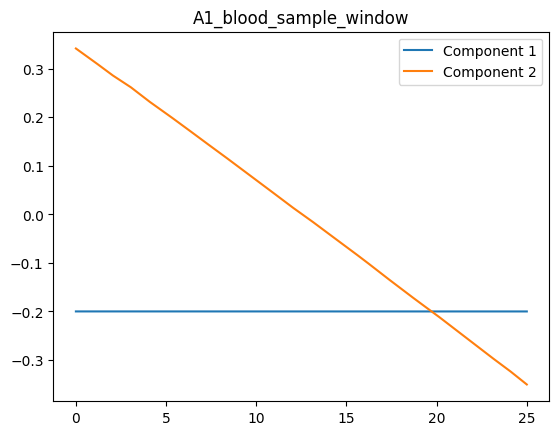

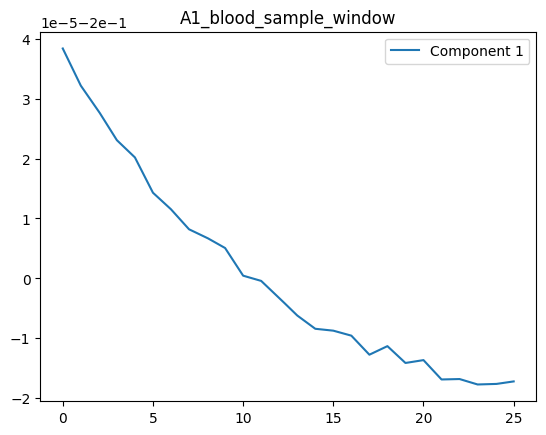

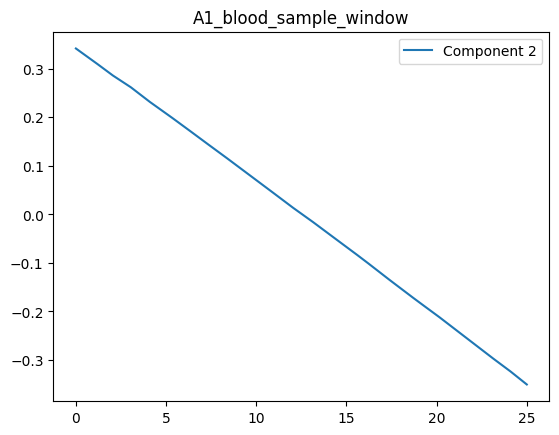

A2_blood_sample_window
Explain variance PC1 (%):  99.99965471489611
Explain variance PC2 (%):  0.0003433848067831412
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -210.059002   -0.414799
TimeSeries_3551012 -151.453268   -0.448871
TimeSeries_3551031 -279.799852   -0.686968
TimeSeries_3551047 -214.428013   -0.434047
TimeSeries_3551065 -203.858991   -0.502776
...                        ...         ...
TimeSeries_3518459 -276.053118   -0.099670
TimeSeries_3518460 -305.040596   -0.588155
TimeSeries_3518431 -180.013621   -0.675405
TimeSeries_3518461   48.106096   -0.471015
TimeSeries_3518462  176.533045   -0.400926

[4724 rows x 2 columns]
The time series contributing most to PC1 is at index 3619 with TestID 3556087
The time series contributing most to PC2 is at index 3069 with TestID 3561214


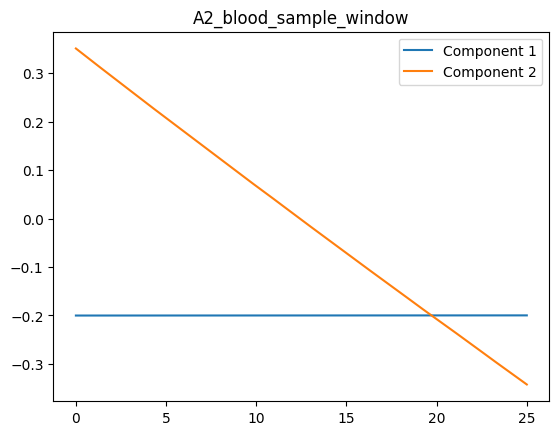

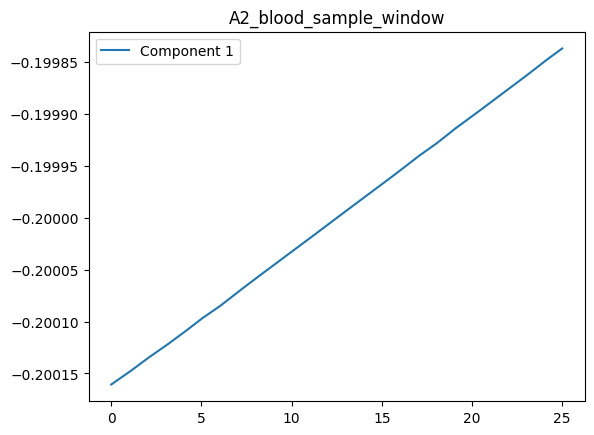

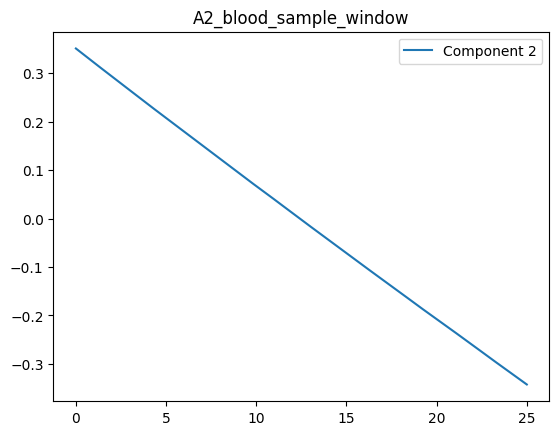

A1_aquous_sample_window
Explain variance PC1 (%):  99.99968069791872
Explain variance PC2 (%):  0.000316059105316455
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372 -489.982772   -0.485935
TimeSeries_12414373 -462.558465   -0.513504
TimeSeries_12414374 -482.552371   -0.487822
TimeSeries_12414375 -463.162436   -0.507979
TimeSeries_12414377 -501.407032   -0.644194
...                         ...         ...
TimeSeries_12470355  354.783372   -0.472967
TimeSeries_12470361  436.176021   -0.387442
TimeSeries_12470365  -20.096427    0.304507
TimeSeries_12539049  -80.129929    0.202356
TimeSeries_12622570  673.851765   -0.585595

[1433 rows x 2 columns]
The time series contributing most to PC1 is at index 1042 with TestID 12573667
The time series contributing most to PC2 is at index 191 with TestID 12615995


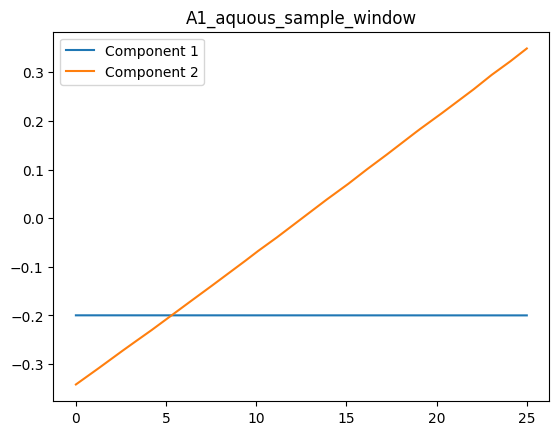

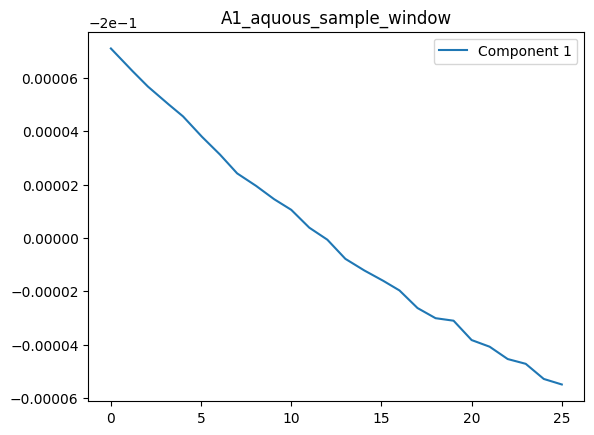

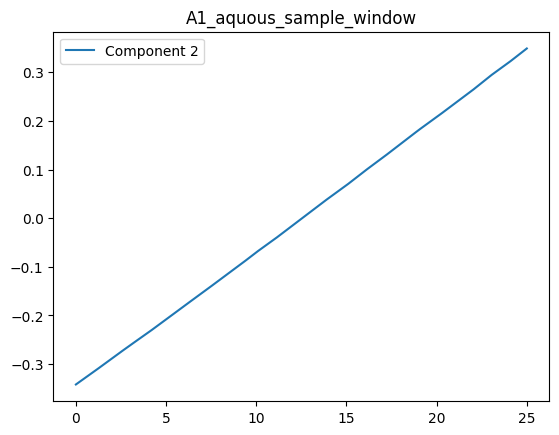

A2_aquous_sample_window
Explain variance PC1 (%):  99.99967268126642
Explain variance PC2 (%):  0.0003265552418817596
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083 -515.248568    0.397099
TimeSeries_3545084 -478.296329    0.380575
TimeSeries_3545085 -389.179817    0.537300
TimeSeries_3545086 -447.029184    0.373680
TimeSeries_3545087 -414.500968    0.421194
...                        ...         ...
TimeSeries_3518708 -414.114940   -0.298086
TimeSeries_3518710  -24.861669   -0.722729
TimeSeries_3518621   94.209446   -0.497800
TimeSeries_3518680 -376.596177   -0.742087
TimeSeries_3518682 -116.766275   -0.776490

[2811 rows x 2 columns]
The time series contributing most to PC1 is at index 2133 with TestID 3572300
The time series contributing most to PC2 is at index 1063 with TestID 3569143


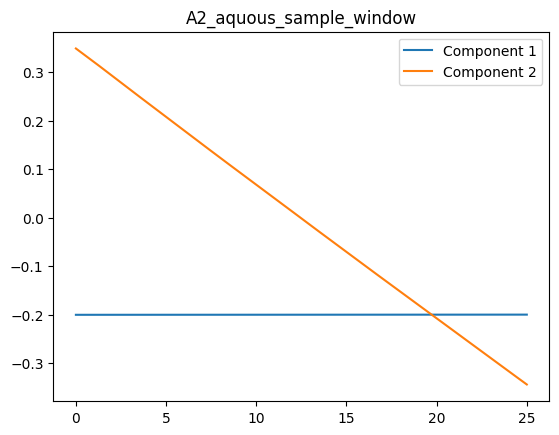

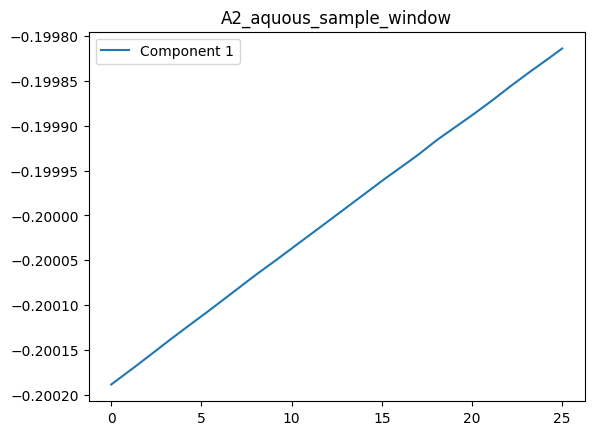

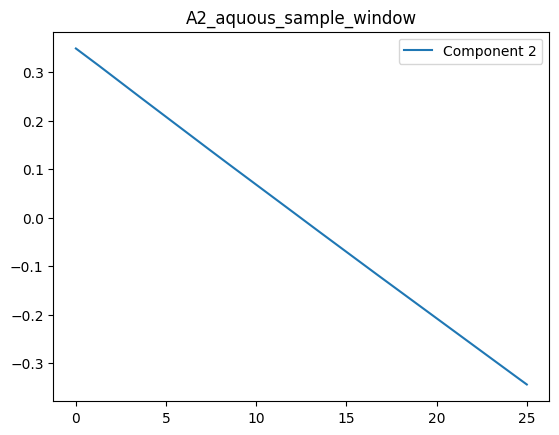

B1_blood_sample_window
Explain variance PC1 (%):  99.99620100809327
Explain variance PC2 (%):  0.003789663009253865
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -112.216634   -0.147633
TimeSeries_12414201 -110.629548   -0.018918
TimeSeries_12414202 -115.538024   -0.060158
TimeSeries_12414203 -122.847068    0.032328
TimeSeries_12414204 -147.902498   -0.031222
...                         ...         ...
TimeSeries_12537664 -227.197382   -0.078896
TimeSeries_12537668 -188.232317   -0.205236
TimeSeries_12624891  187.188919    1.235715
TimeSeries_12624893  163.116044    1.789061
TimeSeries_12537663 -173.113581   -0.214604

[1944 rows x 2 columns]
The time series contributing most to PC1 is at index 240 with TestID 12546591
The time series contributing most to PC2 is at index 452 with TestID 12191207


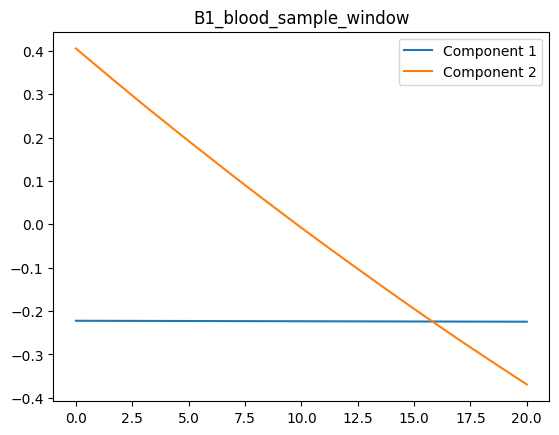

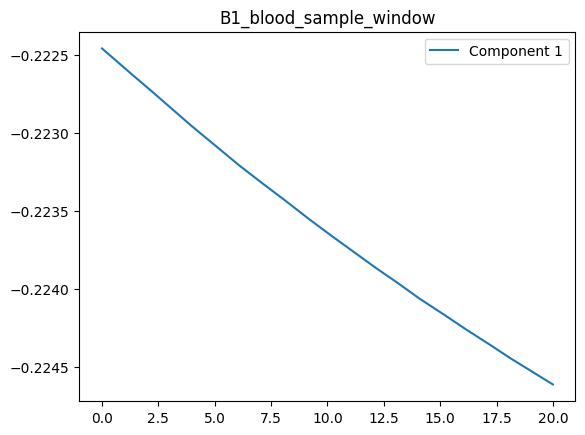

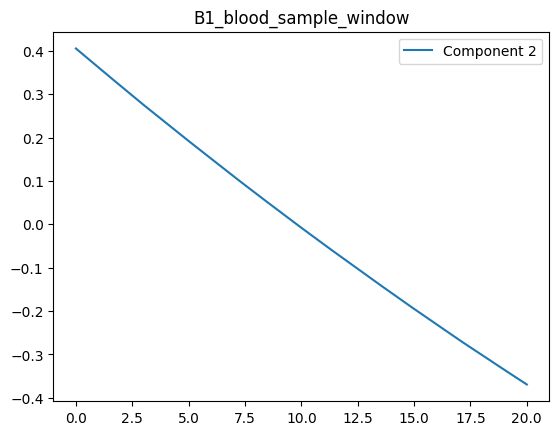

B2_blood_sample_window
Explain variance PC1 (%):  99.99794532419322
Explain variance PC2 (%):  0.0020505592070549014
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995  125.469271   -0.522653
TimeSeries_3551012   75.409797   -0.458847
TimeSeries_3551031  216.979992   -0.288089
TimeSeries_3551047  162.389073   -0.421400
TimeSeries_3551065  123.388533   -0.467927
...                        ...         ...
TimeSeries_3518442  128.978857    2.973429
TimeSeries_3518443    8.285297    2.764683
TimeSeries_3518444   51.254308    2.837675
TimeSeries_3518445  -31.406804    3.156691
TimeSeries_3518456  151.983057    2.868753

[4893 rows x 2 columns]
The time series contributing most to PC1 is at index 418 with TestID 3556268
The time series contributing most to PC2 is at index 4868 with TestID 3518458


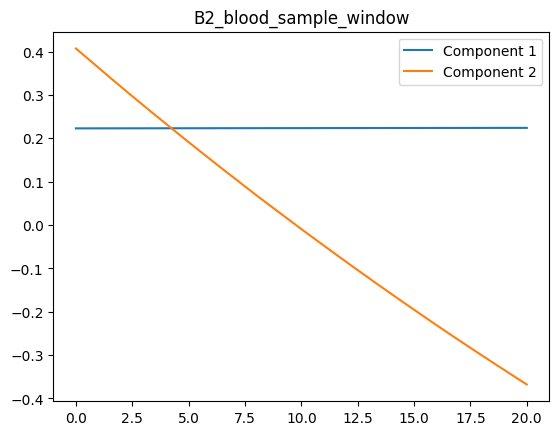

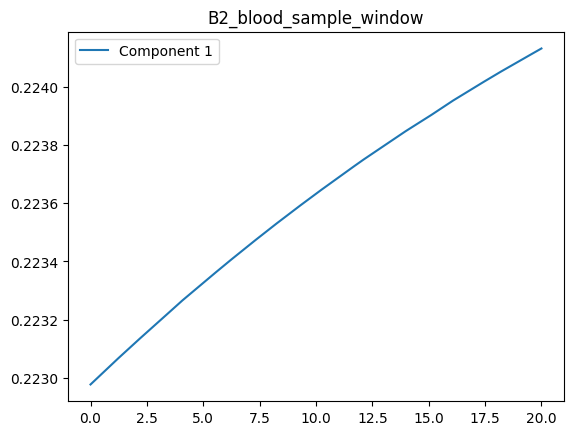

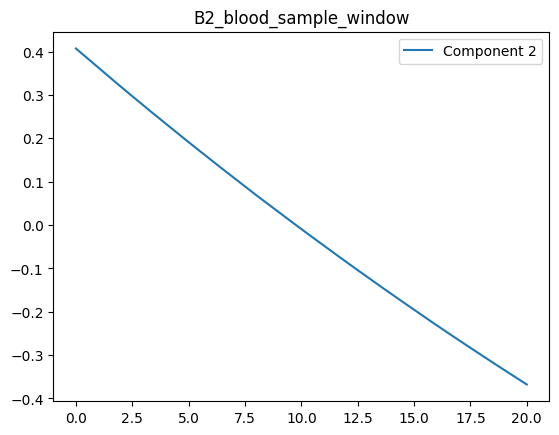

B1_aquous_sample_window
Explain variance PC1 (%):  99.99969297598653
Explain variance PC2 (%):  0.00029589986945259046
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372  182.961892   -0.373822
TimeSeries_12414373  182.249332   -0.359877
TimeSeries_12414374  200.003408   -0.373952
TimeSeries_12414375  198.678505   -0.351537
TimeSeries_12414377  177.869578   -0.310900
...                         ...         ...
TimeSeries_12470355  -70.960339    0.351319
TimeSeries_12470361   17.593421    0.140385
TimeSeries_12470365   47.188853    0.185141
TimeSeries_12539049   45.405345    0.078044
TimeSeries_12622570  -25.167515    0.127562

[1431 rows x 2 columns]
The time series contributing most to PC1 is at index 472 with TestID 12437598
The time series contributing most to PC2 is at index 1044 with TestID 12623840


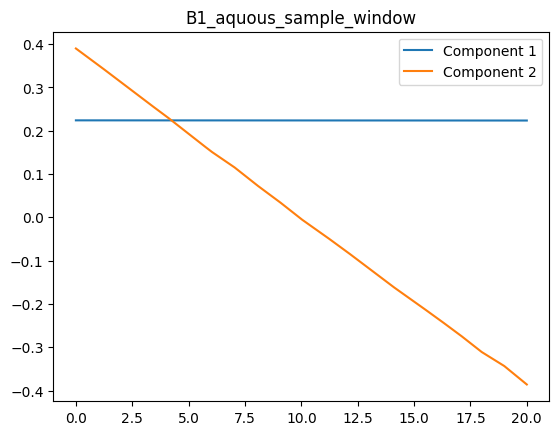

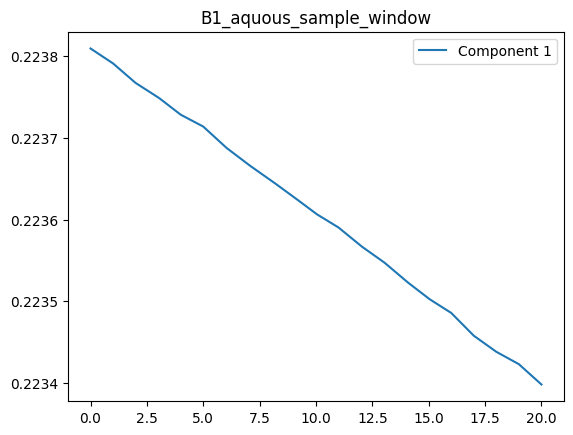

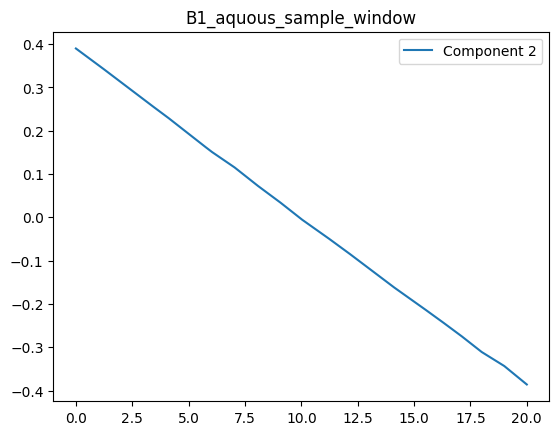

B2_aquous_sample_window
Explain variance PC1 (%):  99.99976387185491
Explain variance PC2 (%):  0.00023388079063263228
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083  262.090591   -0.305224
TimeSeries_3545084  255.026071   -0.312076
TimeSeries_3545085  217.728533   -0.154386
TimeSeries_3545086  261.449605   -0.297389
TimeSeries_3545087  220.446807   -0.279763
...                        ...         ...
TimeSeries_3518583  244.638959    0.482587
TimeSeries_3518675  234.850414    0.495165
TimeSeries_3518676  153.581131    0.528870
TimeSeries_3518677  141.872451    0.683167
TimeSeries_3518678   96.559830    0.676792

[2852 rows x 2 columns]
The time series contributing most to PC1 is at index 212 with TestID 3548492
The time series contributing most to PC2 is at index 2823 with TestID 3518631


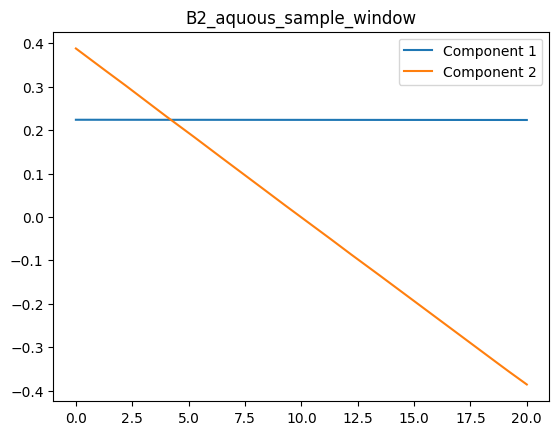

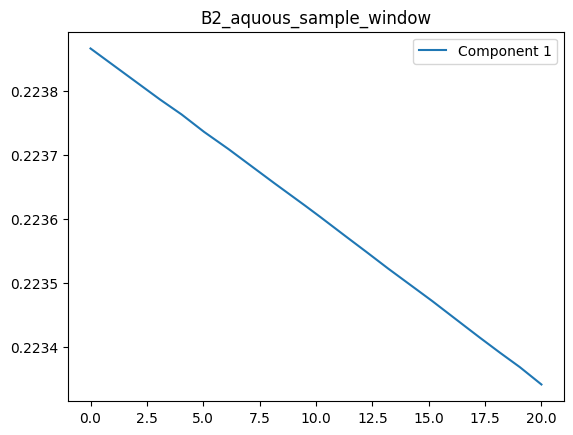

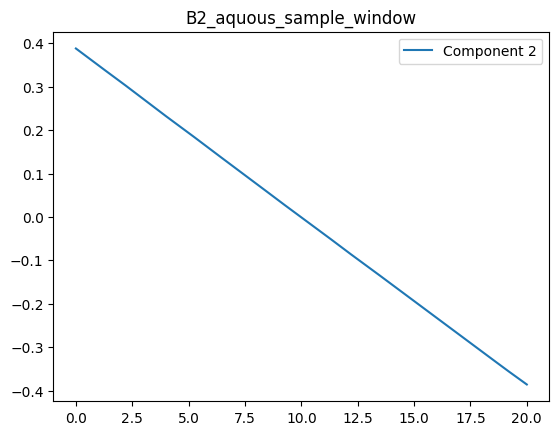

In [ ]:
print("FPCA SAMPLE WINDOW\n")
print("A1_sample_window")
perform_functional_pca(A1_sample_window, "A1_sample_window")
print("A2_sample_window")
perform_functional_pca(A2_sample_window, "A2_sample_window")
print("A1_blood_sample_window")
perform_functional_pca(A1_blood_sample_window, "A1_blood_sample_window")
print("A2_blood_sample_window")
perform_functional_pca(A2_blood_sample_window, "A2_blood_sample_window")
print("A1_aquous_sample_window")
perform_functional_pca(A1_aquous_sample_window, "A1_aquous_sample_window" )
print("A2_aquous_sample_window")
perform_functional_pca(A2_aquous_sample_window, "A2_aquous_sample_window")
print("B1_blood_sample_window")
perform_functional_pca(B1_blood_sample_window, "B1_blood_sample_window")
print("B2_blood_sample_window")
perform_functional_pca(B2_blood_sample_window, "B2_blood_sample_window")
print("B1_aquous_sample_window")
perform_functional_pca(B1_aquous_sample_window, "B1_aquous_sample_window")
print("B2_aquous_sample_window")
perform_functional_pca(B2_aquous_sample_window, "B2_aquous_sample_window")

## 12. Verifying waveforms which contributes the most to PC's shape

In [ ]:
# # PC2 major contributor
# Calibration window
A1_Merged.loc[12615995,1:18]

1.0    -1797.938
1.2    -1797.909
1.4    -1797.879
1.6     -1797.85
1.8    -1797.823
          ...   
17.2    309.2832
17.4    297.9701
17.6    285.8139
17.8    273.0943
18.0    260.6791
Name: 12615995, Length: 86, dtype: object

In [ ]:
# PC2 major contributor
# Sample window
A1_Merged.loc[3561214,1:18]

KeyError: 3561214

In [ ]:
A1_Merged[A1_Merged['TestID'] == 12515535].iloc[:,1:18]

In [ ]:
A1_Merged[A1_Merged['TestID'] == 12390613].iloc[:,1:18]

In [ ]:
A2_Merged[A2_Merged['TestID'] == 3561214].iloc[:,1:18]

In [ ]:
A2_Merged[A2_Merged['TestID'] == 3572300].iloc[:,1:18]
plot_all_time_series(A2_cal_window[A2_cal_window.index == 3572300])


In [ ]:
A2_cal_window[A2_cal_window.index == 3561214]
plot_all_time_series(A2_cal_window[A2_cal_window.index == 3561214])

## 13. Functional One-way Anova

In [ ]:
## 13. Functional One-way Anova

## 14. Functional Regression

In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis

In [38]:
def Function_regression(windows,Merge_dataset,len_time = 40,predictor = ["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"] ):
  # Prepare Data
  # Y_dna = windows.dropna() # drop NA
  merged_column = [list(row) for row in windows.iloc[:, :].to_numpy()] # Make time series table into list
  ## --- change y format ---
  # basis = skfda.representation.basis.MonomialBasis(n_basis=40)
  Y = FDataGrid(merged_column, grid_points = range(len(merged_column[1])))
  basis = FourierBasis(n_basis=len_time) # change FourierBasis
  y = Y.coordinates[0].to_basis(basis)
  ## --- change x format
  # drop_index = windows.loc[windows.isna().sum(axis=1)!=0].index # check the removed test ID
  # New_Merged =Merge_dataset.set_index("TestID")
  x = Merge_dataset.loc[:,predictor]
  # x = X.drop(drop_index)

  # Fit the model
  funct_reg = LinearRegression(fit_intercept=True)
  funct_reg.fit(x, y)

  print("To Check if we need to move any time stamp","\n")
  intercept = funct_reg.intercept_
  print("The Intercept of this model is:",intercept,"\n")
  for i in range(len(predictor)):
    coef = funct_reg.coef_[i]
    print("The coefficient of {} of this model is:{}".format(predictor[i],coef),"\n")
  return funct_reg

In [39]:
def coefficent_visualization(funct_reg,funct_reg2,predictor,interval):
  # Intercept
  print(funct_reg.intercept_.coefficients[0][interval])
  y = funct_reg.intercept_.coefficients[0][interval]
  y2 = funct_reg2.intercept_.coefficients[0][interval]
  x = np.arange(len(funct_reg.intercept_.coefficients[0][interval]))
  plt.plot(x, y, label='intercept in system1')
  plt.plot(x, y2, label='intercept in system2')
  plt.legend()
  plt.title("Intercept")
  plt.show()

  # Coefficient
  for i in range(len(predictor)):
    print(funct_reg.coef_[i].coefficients[0][interval])
    y = funct_reg.coef_[i].coefficients[0][interval]
    y2 = funct_reg2.coef_[i].coefficients[0][interval]
    x = np.arange(len(funct_reg.coef_[i].coefficients[0][interval]))
    plt.title(predictor[i])
    plt.plot(x,y,label='Coefficient in system1')
    plt.plot(x,y2,label='Coefficient in system2')
    plt.legend()
    plt.show()


In [42]:
# Regression on AmbientTemperature
print("For Calibration windows")
A1_cal_window_funct_reg = Function_regression(A1_cal_window,A1_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
A2_cal_window_funct_reg = Function_regression(A2_cal_window,A2_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
A1_blood_cal_window_funct_reg = Function_regression(A1_blood_cal_window,A1_blood_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
A2_blood_cal_window_funct_reg = Function_regression(A2_blood_cal_window,A2_blood_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
A1_aquous_cal_window_funct_reg = Function_regression(A1_aquous_cal_window,A1_aquous_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
A2_aquous_cal_window_funct_reg = Function_regression(A2_aquous_cal_window,A2_aquous_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
B1_blood_cal_window_funct_reg = Function_regression(B1_blood_cal_window,B1_blood_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
B2_blood_cal_window_funct_reg = Function_regression(B2_blood_cal_window,B2_blood_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
B1_aquous_cal_window_funct_reg = Function_regression(B1_aquous_cal_window,B1_aquous_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
B2_aquous_cal_window_funct_reg = Function_regression(B2_aquous_cal_window,B2_aquous_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


print("For Sample windows")
A1_sample_window_funct_reg = Function_regression(A1_sample_window,A1_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
A2_sample_window_funct_reg = Function_regression(A2_sample_window,A2_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
A1_blood_sample_window_funct_reg = Function_regression(A1_blood_sample_window,A1_blood_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
A2_blood_sample_window_funct_reg = Function_regression(A2_blood_sample_window,A2_blood_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
A1_aquous_sample_window_funct_reg = Function_regression(A1_aquous_sample_window,A1_aquous_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
A2_aquous_sample_window_funct_reg = Function_regression(A2_aquous_sample_window,A2_aquous_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
B1_blood_sample_window_funct_reg = Function_regression(B1_blood_sample_window,B1_blood_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
B2_blood_sample_window_funct_reg = Function_regression(B2_blood_sample_window,B2_blood_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
B1_aquous_sample_window_funct_reg = Function_regression(B1_aquous_sample_window,B1_aquous_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
B2_aquous_sample_window_funct_reg = Function_regression(B2_aquous_sample_window,B2_aquous_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])



For Calibration windows
To Check if we need to move any time stamp 

The Intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 40.0),), n_basis=41, period=40.0),
    coefficients=[[ 5.92082473e+02 -8.32864809e+00  5.45340397e-01 -2.36651385e+00
       1.34856250e+01 -4.08636507e+00 -2.33509668e+01 -2.86720581e+00
      -2.75307256e+00 -2.48635423e+00 -1.04602093e+01 -2.03608625e+01
       3.65521658e+00 -7.71848475e+00 -1.42479992e+00 -2.11826624e+01
      -1.35088579e+01 -6.94423597e-02  1.26963891e+01  1.00354259e+01
      -4.02027857e-01  1.81095387e+01 -1.23411411e+01  6.37407772e+00
      -1.42412031e+01 -1.15895289e+01 -1.69634495e+01  6.52839458e+00
      -1.64810117e+00  4.40676669e-01  1.02338502e+01  1.57378409e+01
      -1.91766437e+01 -1.19574206e+01 -2.64387933e+01  7.57907253e+00
       1.56945036e+01  7.66690287e+00 -1.20356508e+01 -5.44011773e+14
       8.43465258e-01]]) 

The coefficient of AmbientTemperature of this model is:FDataBasis(
 

Sensor A
[ -8.32864809   0.5453404   -2.36651385  13.48562498  -4.08636507
 -23.35096679  -2.86720581  -2.75307256  -2.48635423 -10.4602093
 -20.36086246   3.65521658  -7.71848475  -1.42479992 -21.18266244
 -13.50885785  -0.06944236  12.69638907  10.03542592  -0.40202786
  18.10953872 -12.34114107   6.37407772 -14.24120312 -11.58952888
 -16.96344954   6.52839458  -1.64810117   0.44067667  10.23385018
  15.73784086 -19.17664367 -11.95742061 -26.43879329   7.57907253
  15.69450356   7.66690287 -12.03565084]


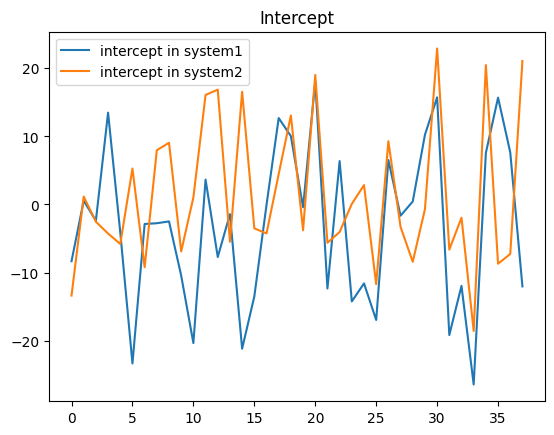

[ 0.37106858 -0.02285153  0.10326479 -0.61003475  0.18480483  1.05223724
  0.12487653  0.12286943  0.11614034  0.47144519  0.91653381 -0.15754183
  0.34871147  0.062853    0.95014531  0.61701918  0.00598263 -0.56789089
 -0.46822331  0.02097382 -0.81323515  0.55520298 -0.29256334  0.64174843
  0.5254662   0.76610185 -0.29713747  0.0769047  -0.03316071 -0.46670734
 -0.71617077  0.86285037  0.53613115  1.19916759 -0.34024425 -0.7048375
 -0.34827956  0.53824831]


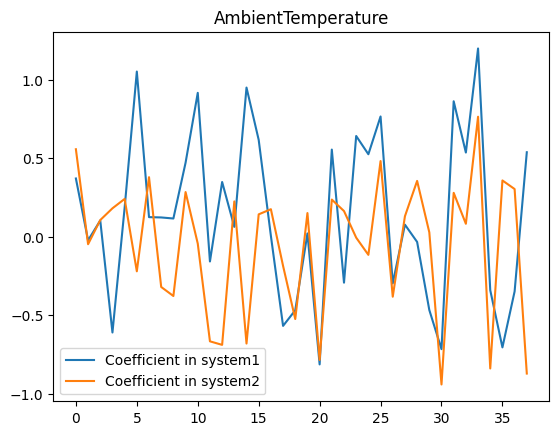

[-5.69807883e-03  1.52943657e-04 -3.14406380e-03 -2.52484998e-03
 -2.74964052e-03  1.79056558e-03 -7.06491865e-04 -4.07680662e-03
  6.56828529e-03  1.26163584e-03 -1.19393986e-06  3.48441724e-03
 -1.97050146e-03  8.72569973e-04  1.08189137e-03  3.90328430e-03
  7.91733783e-04  7.20002940e-04 -1.11552194e-02  1.39128204e-03
 -7.04227498e-04 -1.67146765e-03 -8.09743984e-04  3.15056338e-04
 -2.12364907e-03 -9.23662090e-05 -1.18538157e-03  5.13862581e-03
 -6.92149391e-03 -1.61935617e-05 -1.65907537e-03 -4.81855524e-03
 -1.60934193e-03  3.35190380e-05 -4.42745550e-03 -3.64586888e-03
 -6.72787667e-03  8.84854298e-04]


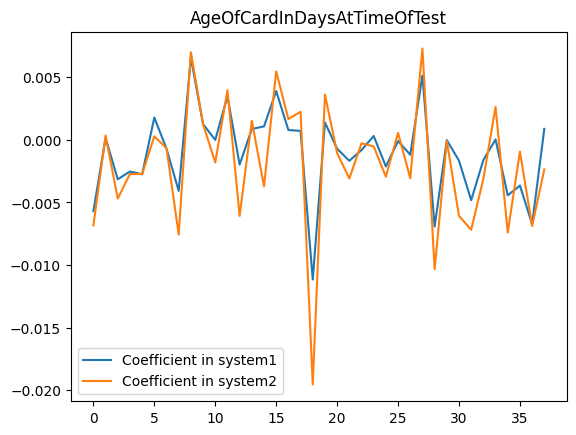


 For blood_cal_window
[ 13.65857703   1.12053454   4.63999972  -4.7671962    7.93873567
  -0.12929551  -6.20694388  -1.08377685  -9.52597312  -1.43051166
 -10.21184717   2.35385841   2.60999503   5.10844491  -7.65208275
  -6.17159039   0.64343568  -9.47677323 -12.34495417  -6.66694045
   0.44888997  -3.18181391  -9.19225345  10.29615737  -2.84610892
   8.24388697 -22.30564772   8.32133983  -1.56879573  -3.01569585
  -4.97789725  -5.74197768   7.90001143  -2.75578706   5.92101914
  -1.63487688   3.92496363  27.18829264]


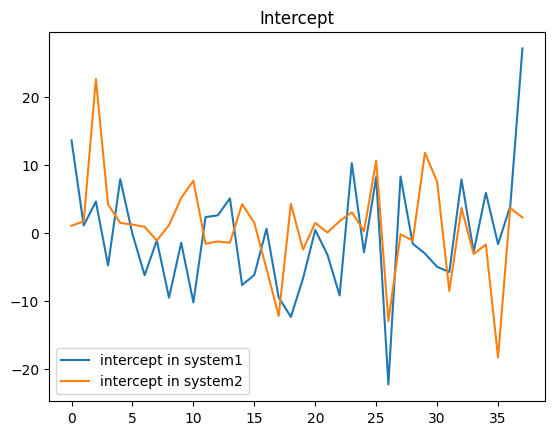

[-0.62191539 -0.05206838 -0.21202399  0.21233196 -0.35641388  0.00611855
  0.27874672  0.04659374  0.43600859  0.06678593  0.46044917 -0.10205781
 -0.12034885 -0.23103435  0.34215144  0.27968026 -0.02862786  0.42749706
  0.54920391  0.30535738 -0.02353635  0.14060289  0.4114733  -0.4640791
  0.13118009 -0.37158541  1.00379656 -0.36799237  0.06625743  0.13800685
  0.22067432  0.25921545 -0.35910724  0.12366667 -0.26883529  0.0706372
 -0.1807071  -1.22831658]


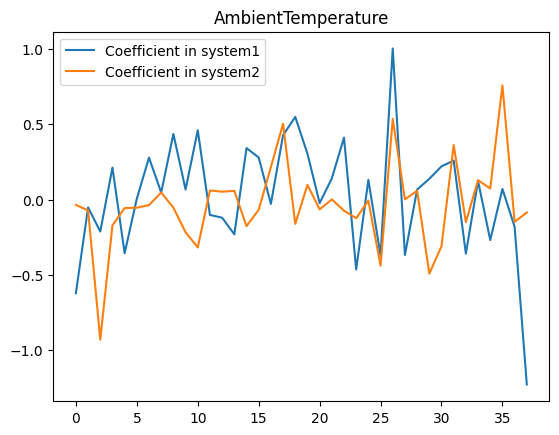

[-6.95886897e-03  7.85064248e-04 -3.91180205e-03 -1.21931108e-03
 -4.15511722e-03  8.00372015e-05 -1.07888215e-03 -3.99483626e-03
  6.60925971e-03  3.10883431e-04 -7.66576334e-04  4.26848045e-03
 -2.05586005e-03  5.51154888e-04 -1.69382915e-04  4.86206476e-03
  1.10942212e-03  3.09511362e-03 -1.13908675e-02  1.24351787e-03
  1.92013605e-03 -1.83288463e-03  2.58995186e-04 -1.57152201e-03
 -2.51328829e-03 -1.73264086e-03  5.89128456e-04  3.47492601e-03
 -8.48490312e-03 -6.78012899e-04 -1.10382077e-03 -6.39755504e-03
 -2.97619089e-03 -3.16208712e-04 -3.62726517e-03 -1.42064932e-03
 -6.21176627e-03 -1.65521598e-03]


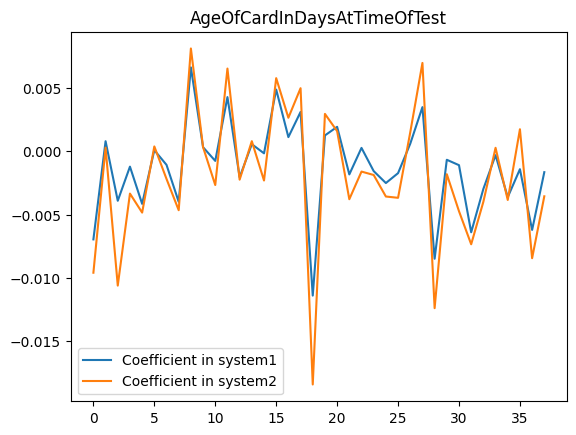


 For aqueous_cal_window
[  52.25575105   50.8293472   -69.06299635  -27.68123802  -25.79770293
  -26.5521288    -9.82552827 -104.98177999  -40.45164826  -20.70319884
  -57.57219425   92.46064609   37.47062705   57.31229173   78.18454553
   29.39692679  110.17766111  -83.24617989  -21.72868156  138.68501249
  -73.81630291  -19.33378466  -23.82337584  -46.83861128  -33.95699265
  -35.48978632  -75.41663345   -6.17603005  -41.18240218 -160.92576472
  -82.08108318   36.96157824  228.88242126  -12.94734752  -77.65898552
   -1.40626584  -67.16573093   35.25476781]


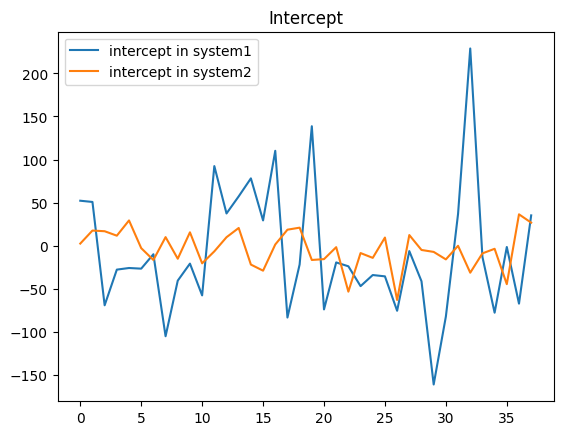

[ -2.36806548  -2.28563359   3.11103709   1.24392436   1.16785858
   1.19459436   0.43557218   4.73365068   1.8304161    0.93018448
   2.59427674  -4.16584346  -1.69753955  -2.57073983  -3.53838757
  -1.31598446  -4.97653774   3.75324812   0.96926644  -6.25272694
   3.33991049   0.87101567   1.07920805   2.11642887   1.52869306
   1.59894052   3.4058228    0.27999237   1.84723873   7.25644456
   3.71047094  -1.68173246 -10.33118451   0.57497354   3.49406555
   0.06743555   3.02874756  -1.60549426]


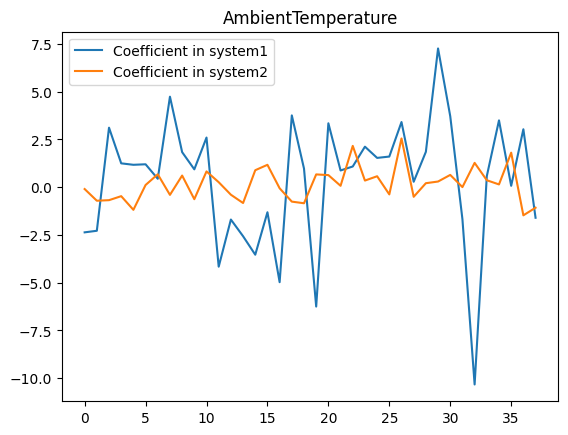

[-0.008276   -0.00359735  0.00068421  0.00047535 -0.00208435  0.00225898
  0.00015751  0.0021135   0.00840249  0.00246742  0.00250016 -0.0012026
 -0.0032682  -0.00506273 -0.00408648  0.00129815 -0.00423918  0.00725788
 -0.00970999 -0.00702927  0.00359289 -0.00116475 -0.00054972  0.00146127
  0.0003291   0.00139926  0.00218454  0.00557579 -0.00460753  0.00954943
  0.00139827 -0.00607835 -0.01488919  0.00207542  0.00232776 -0.00242847
 -0.00248444 -0.00017572]


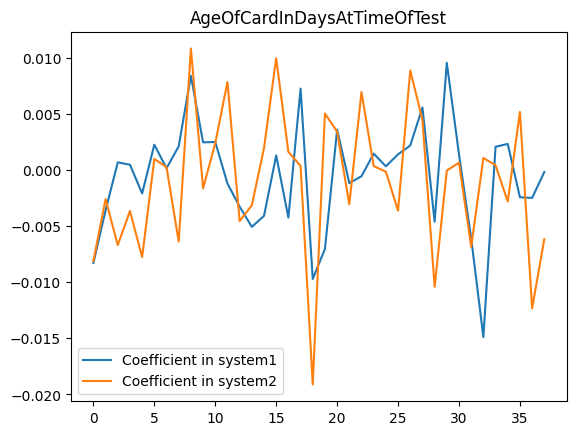


 For blood_cal_window
Sensor B
[-1.26980798e+01 -2.53217292e-01 -6.33435962e+00 -6.79481963e-02
 -4.22218682e+00 -2.17141177e-02 -3.15472216e+00 -1.10810932e-02
 -2.51693816e+00 -1.92260263e-02 -2.09252782e+00 -4.99002762e-03
 -1.77306541e+00 -4.46860012e-03 -1.54084843e+00 -2.35235503e-03
 -1.36870734e+00  2.53152274e-03 -1.21566924e+00  2.02717520e-03
 -1.09080613e+00 -4.65089135e-03 -9.91580023e-01 -1.79506250e-03
 -9.08517326e-01  5.99655465e-04 -8.36576983e-01 -1.34384268e-03
 -7.66371783e-01  1.22291146e-03 -7.07219473e-01 -3.13427519e-03
 -6.61549719e-01  8.37018704e-04 -6.12740784e-01  1.94337448e-03
 -5.65840628e-01 -8.62718754e-03 -5.28742259e-01]


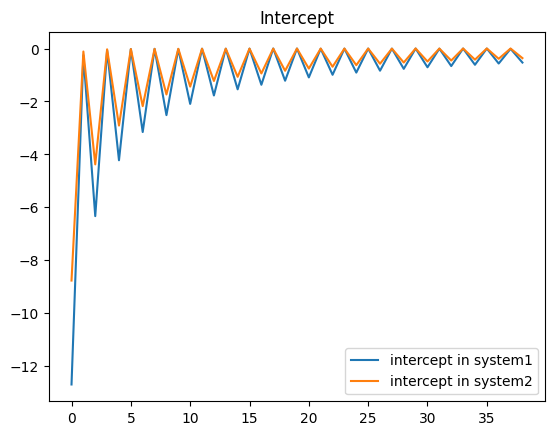

[ 2.43138625e-01  8.55534552e-03  1.21311289e-01  2.48309687e-03
  8.10658507e-02  7.51415425e-04  6.04910764e-02  3.91089330e-04
  4.83975107e-02  7.61100276e-04  4.03412421e-02  1.45746333e-04
  3.38927216e-02  1.30358397e-04  2.94609778e-02  8.61131908e-05
  2.63974036e-02 -1.75819927e-04  2.32655284e-02 -1.14584064e-04
  2.07801935e-02  1.87112421e-04  1.89490348e-02  6.68661131e-05
  1.73899047e-02 -3.93011137e-05  1.61152956e-02  5.21039090e-05
  1.46873149e-02 -5.96274624e-05  1.35497364e-02  1.29730687e-04
  1.27941652e-02 -3.88594387e-05  1.18244299e-02 -7.06243803e-05
  1.08337443e-02  3.48420681e-04  1.01598905e-02]


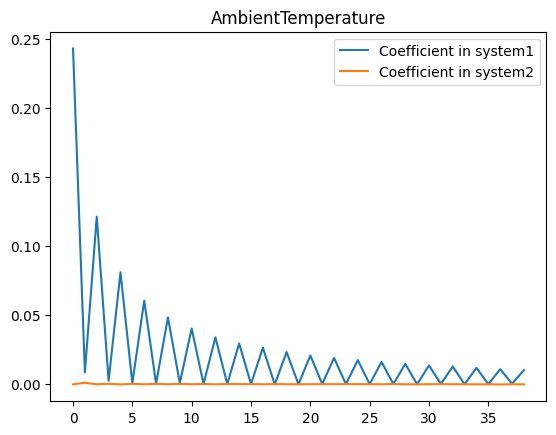

[ 2.16584421e-03 -2.45759701e-04  1.11193771e-03 -6.75784435e-05
  7.43883144e-04 -3.42634548e-05  5.60636285e-04 -2.05365829e-05
  4.35591331e-04 -8.00263931e-06  3.65891569e-04 -3.36572717e-06
  3.11501501e-04 -5.14164997e-06  2.66912924e-04 -9.44776215e-06
  2.36312883e-04  5.06499311e-07  2.14888196e-04 -5.61824537e-06
  1.89582106e-04 -1.07546604e-06  1.73559791e-04 -5.33628640e-07
  1.63809446e-04  7.44071363e-07  1.50481907e-04 -2.52877528e-06
  1.31121458e-04 -1.85945330e-06  1.18578879e-04 -4.00816211e-07
  1.18195273e-04 -6.38878306e-06  1.08445752e-04 -6.10594386e-06
  9.45829251e-05  2.29604111e-06  9.33027616e-05]


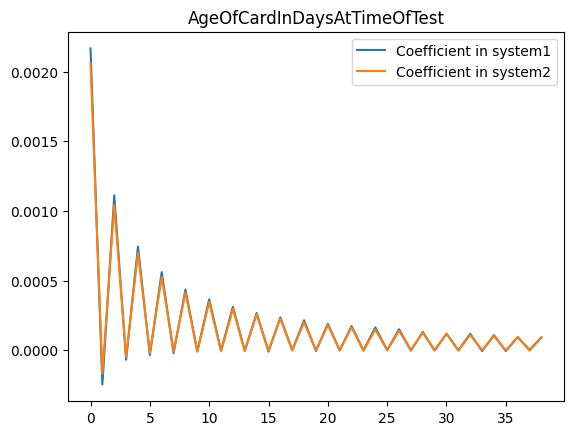


 For aqueous_cal_window
[-1.17107647e+01 -1.05160288e-01 -5.81929313e+00 -2.62576735e-02
 -3.89952359e+00  1.29996477e-02 -2.89312211e+00  2.72752826e-03
 -2.31262449e+00 -2.36349213e-02 -1.89368592e+00 -1.82859089e-02
 -1.62768330e+00 -2.27865935e-02 -1.40241413e+00  1.30793105e-02
 -1.24202444e+00 -8.81164854e-04 -1.11557600e+00  5.78247217e-03
 -1.00859765e+00 -6.71816887e-03 -9.19662242e-01 -1.29476072e-02
 -8.35118188e-01 -8.21034630e-03 -7.63972886e-01 -9.21248076e-05
 -7.05337549e-01 -3.11417507e-03 -6.58702007e-01  1.96858342e-03
 -6.00589277e-01 -3.27893130e-03 -5.52208639e-01 -6.11275314e-03
 -5.21831539e-01 -2.99759019e-05 -4.72108079e-01]


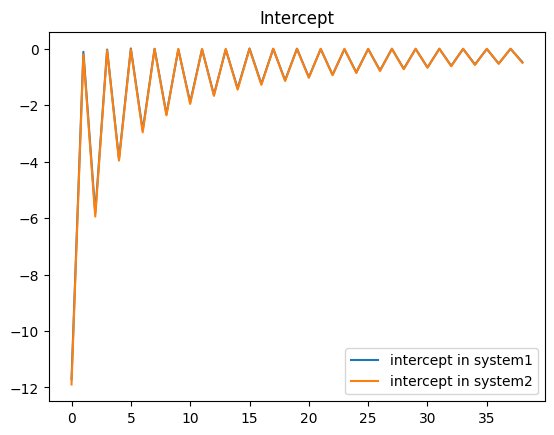

[ 1.64092567e-01  1.76244763e-03  8.09761917e-02  5.74916062e-04
  5.51882339e-02 -8.49852979e-04  4.02564531e-02 -3.39557252e-04
  3.23876348e-02  9.67385134e-04  2.57927802e-02  7.16546176e-04
  2.25420902e-02  9.80629002e-04  1.90521267e-02 -6.58644867e-04
  1.70323628e-02 -1.39308493e-05  1.54686773e-02 -3.27731710e-04
  1.41407549e-02  2.81230010e-04  1.29638585e-02  5.67001456e-04
  1.16266450e-02  3.28045868e-04  1.05995744e-02 -8.68435693e-06
  9.83521422e-03  1.33135624e-04  9.41581210e-03 -1.36934037e-04
  8.32626327e-03  1.15466544e-04  7.45354036e-03  2.42110896e-04
  7.30725913e-03 -1.26539586e-05  6.19008947e-03]


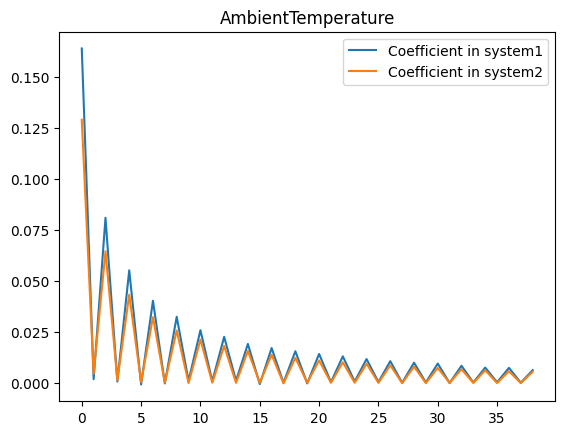

[ 6.86285575e-03 -2.74832702e-04  3.42335030e-03 -7.63418630e-05
  2.28205330e-03 -2.84721426e-05  1.70020080e-03 -8.95761463e-06
  1.35937624e-03 -1.28300368e-05  1.12069794e-03 -2.33967479e-06
  9.60172994e-04 -7.36425261e-06  8.29456465e-04 -1.29785781e-07
  7.26467727e-04  6.81542896e-07  6.60500889e-04  3.91741394e-06
  5.86471794e-04 -1.41147281e-07  5.39826350e-04 -3.60096009e-06
  4.97872867e-04  3.85331862e-07  4.48599014e-04 -3.10970643e-06
  4.16510430e-04 -7.93386965e-07  3.82655518e-04  3.64448456e-06
  3.49086960e-04  7.90803560e-07  3.27561885e-04  1.00666142e-06
  3.07105120e-04  1.40286176e-06  2.83519767e-04]


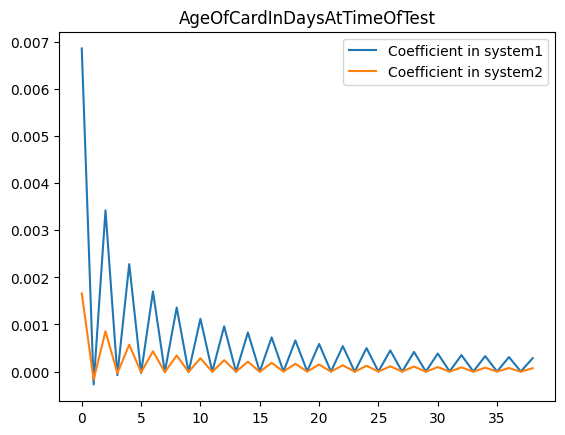


 For sample_window
Sensor A
[ 5.37231237e+02 -2.95146276e-01 -1.56538235e-01 -7.00195435e-01
  5.24241798e-01  2.83347140e-01  2.45209144e-04 -2.50846287e-01
  8.01900197e-01  1.19472974e+12 -1.35467088e-01 -1.91639846e+11
  4.37620705e-01 -1.91639846e+11  2.30673099e-01 -4.35074860e+12
 -5.94481210e-01 -1.57800943e+12 -9.00407179e-02 -1.91639846e+11
  2.54698416e-02 -2.96437902e+12 -1.16607255e-01 -1.91639846e+11
  3.46211203e-01 -1.91639846e+11  2.81740561e-02 -2.96437902e+12
  3.07166769e-01 -1.91639846e+11  5.26739677e-02 -1.57800943e+12
  8.92062781e-02 -4.35074860e+12 -3.50903060e-01 -1.91639846e+11
  1.52086339e-01 -1.91639846e+11  7.13132065e-02  1.19472974e+12]


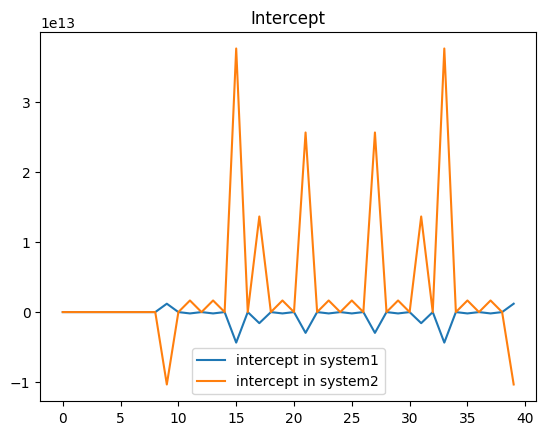

[-1.95696423e+01  2.00966808e-02  7.75375920e-03  3.50111213e-02
 -2.30729639e-02 -1.01476817e-02  2.84020489e-04  1.33838362e-02
 -3.58546342e-02  1.00434594e+11  7.08957704e-03 -1.61101456e+10
 -1.95405030e-02 -1.61101456e+10 -1.12557533e-02 -3.65744363e+11
  3.05014724e-02 -1.32654885e+11  5.26241287e-03 -1.61101456e+10
 -8.38461672e-04 -2.49199624e+11  8.42757315e-03 -1.61101456e+10
 -1.48986398e-02 -1.61101456e+10 -8.30958448e-04 -2.49199624e+11
 -1.25654378e-02 -1.61101456e+10 -2.06957798e-03 -1.32654885e+11
 -4.38383065e-03 -3.65744363e+11  1.66509456e-02 -1.61101456e+10
 -6.77854167e-03 -1.61101456e+10 -3.08014561e-03  1.00434594e+11]


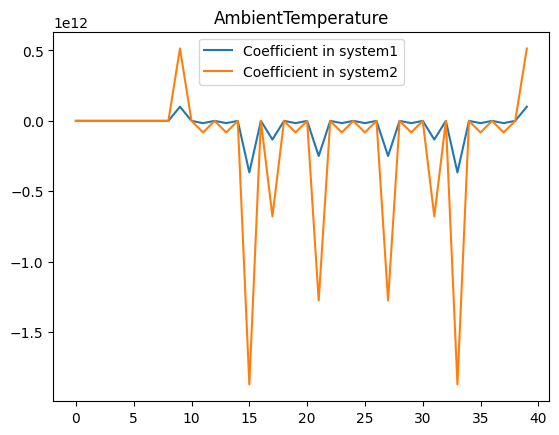

[-2.14022779e+00 -2.05530451e-03  1.24489747e-04 -9.72558538e-04
 -1.16501214e-04 -8.02282877e-04 -2.44558718e-05 -6.04018663e-04
 -1.37448009e-04 -4.51654833e+10 -2.47717518e-04  7.24473994e+09
 -7.77232318e-05  7.24473994e+09  1.77749594e-04  1.64475410e+11
 -1.02850961e-03  5.96549632e+10 -3.32246788e-04  7.24473994e+09
 -1.05633837e-04  1.12065186e+11 -9.20432687e-04  7.24473994e+09
 -2.40156540e-04  7.24473994e+09 -1.09549452e-04  1.12065186e+11
 -4.10858777e-04  7.24473994e+09 -9.79613931e-05  5.96549632e+10
  7.20081016e-05  1.64475410e+11 -2.22991337e-04  7.24473994e+09
 -3.27336778e-05  7.24473994e+09 -3.31634670e-05 -4.51654833e+10]


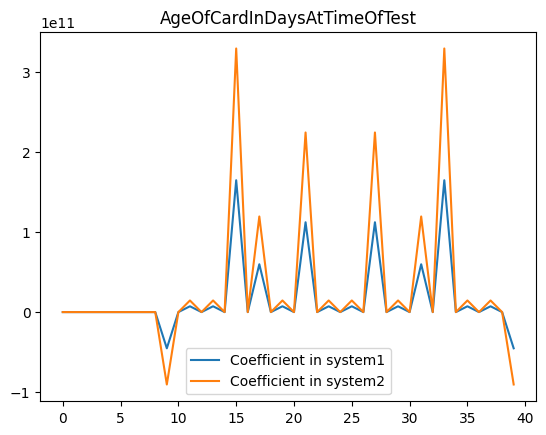


 For blood_sample_window
[ 4.63898380e+02  1.48418481e-01 -1.45986587e-01 -2.95597774e-01
 -1.08901757e-01 -3.44125734e-01 -6.87767891e-01  3.59676743e-01
 -1.22044175e-01  8.16221867e+11  5.32845829e-01 -1.30925537e+11
 -2.74178492e-01 -1.30925537e+11  2.04035464e-01 -2.97236775e+12
  1.86841941e-02 -1.07807294e+12 -7.43929460e-01 -1.30925537e+11
 -3.23438985e-01 -2.02522034e+12 -3.71195435e-02 -1.30925537e+11
 -2.10852452e-01 -1.30925537e+11  2.66812679e-01 -2.02522034e+12
  1.74579666e-01 -1.30925537e+11  1.45273597e+00 -1.07807294e+12
  3.05195133e-01 -2.97236775e+12 -1.53582294e-01 -1.30925537e+11
 -1.15837584e-01 -1.30925537e+11 -1.60134270e-02  8.16221867e+11]


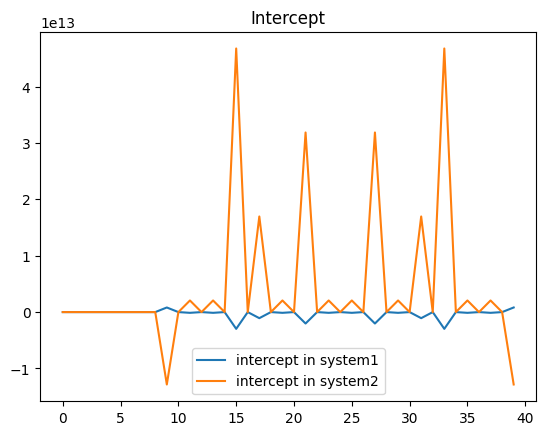

[-1.59447671e+01  2.11107143e-03  7.36348447e-03  1.75485079e-02
  5.77011114e-03  1.92179913e-02  3.12305987e-02 -1.35941727e-02
  6.19246417e-03  1.54552396e+11 -2.30727415e-02 -2.47908764e+10
  1.28750077e-02 -2.47908764e+10 -9.65874335e-03 -5.62820693e+11
  3.44071677e-03 -2.04134149e+11  3.49279452e-02 -2.47908764e+10
  1.53874496e-02 -3.83477421e+11  5.63751040e-03 -2.47908764e+10
  1.06160777e-02 -2.47908764e+10 -1.15684102e-02 -3.83477421e+11
 -6.08313272e-03 -2.47908764e+10 -6.50071840e-02 -2.04134149e+11
 -1.38619363e-02 -5.62820693e+11  8.10009969e-03 -2.47908764e+10
  5.23777054e-03 -2.47908764e+10  7.31756422e-04  1.54552396e+11]


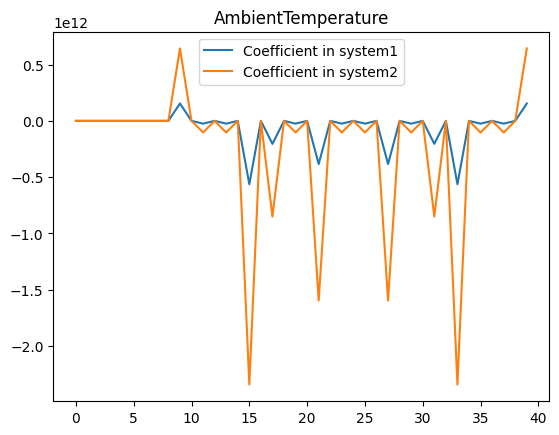

[-2.15706932e+00 -2.17141615e-03  1.18290088e-04 -1.00143766e-03
 -1.07966901e-04 -8.47373248e-04  3.44827585e-05 -6.55263345e-04
 -1.42374427e-04 -4.58571159e+10 -2.56117709e-04  7.35568082e+09
 -9.12907616e-05  7.35568082e+09  9.71861419e-05  1.66994071e+11
 -1.03734590e-03  6.05684775e+10 -2.75411127e-04  7.35568082e+09
 -1.62639074e-04  1.13781274e+11 -9.42343956e-04  7.35568082e+09
 -2.45889729e-04  7.35568082e+09 -1.42540328e-04  1.13781274e+11
 -4.32947432e-04  7.35568082e+09 -2.12948534e-04  6.05684775e+10
  1.31935016e-05  1.66994071e+11 -2.57268881e-04  7.35568082e+09
  4.68585145e-06  7.35568082e+09 -2.84062886e-07 -4.58571159e+10]


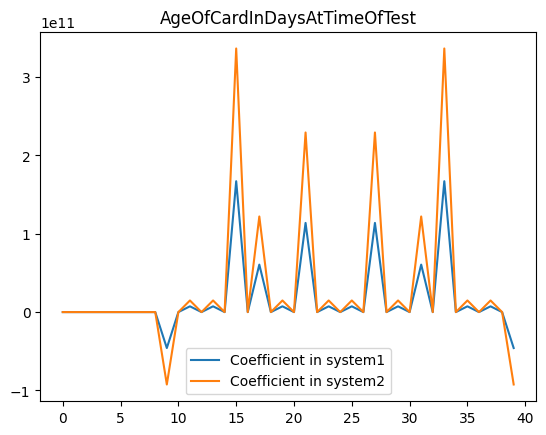


 For aqueous_sample_window
[ 1.04442697e+03 -4.65285757e+00  5.98509676e-01  1.86533223e+00
  2.50297626e+00 -9.51863157e-01 -9.87932538e-01  7.90136490e-01
 -1.43633985e+00  5.55812616e+12 -3.18072194e+00 -8.91547607e+11
  2.92593314e+00 -8.91547607e+11  8.75208140e-01 -2.02405689e+13
  1.53273611e+00 -7.34122137e+12 -3.79402004e+00 -8.91547607e+11
  3.79245147e+00 -1.37908951e+13  1.41007898e+00 -8.91547607e+11
  2.56479101e+00 -8.91547607e+11 -1.26041782e+00 -1.37908951e+13
  2.46331044e+00 -8.91547607e+11 -2.84173215e+00 -7.34122137e+12
  2.43073835e+00 -2.02405689e+13  1.08745779e+00 -8.91547607e+11
 -3.02131313e+00 -8.91547607e+11 -1.28268262e+00  5.55812616e+12]


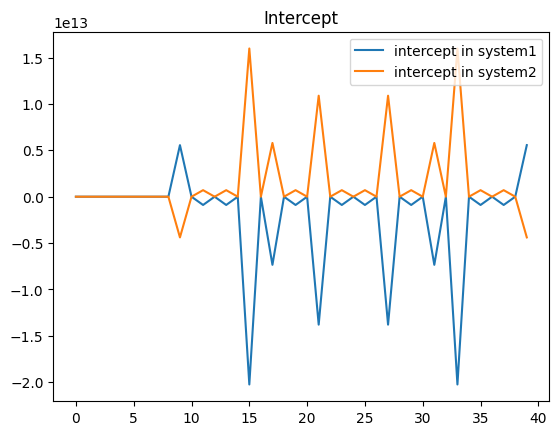

[-4.30981150e+01  2.13238820e-01 -2.64161708e-02 -8.20412791e-02
 -1.12320193e-01  4.43755401e-02  4.49676324e-02 -3.44656428e-02
  6.55409459e-02 -1.72146022e+11  1.44062069e-01  2.76129706e+10
 -1.31707136e-01  2.76129706e+10 -3.94319558e-02  6.26889949e+11
 -6.72178390e-02  2.27371963e+11  1.72117165e-01  2.76129706e+10
 -1.70682284e-01  4.27130956e+11 -6.19110239e-02  2.76129706e+10
 -1.14925680e-01  2.76129706e+10  5.71340277e-02  4.27130956e+11
 -1.10270593e-01  2.76129706e+10  1.27859110e-01  2.27371963e+11
 -1.09627525e-01  6.26889949e+11 -4.85953263e-02  2.76129706e+10
  1.36529574e-01  2.76129706e+10  5.77246954e-02 -1.72146022e+11]


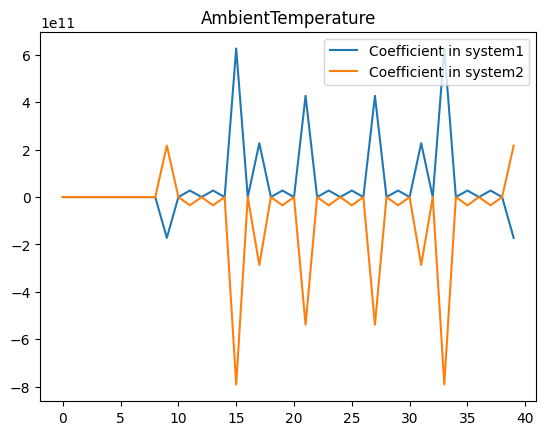

[-2.10627480e+00 -1.54790828e-03  1.03380897e-04 -1.07798324e-03
 -2.71475686e-04 -6.57898951e-04  1.60847208e-05 -6.24913615e-04
 -9.35493773e-05 -3.98351103e+10 -4.13575044e-05  6.38972493e+09
 -2.57765765e-04  6.38972493e+09  1.88528056e-05  1.45064231e+11
 -1.02343743e-03  5.26145602e+10 -1.24093953e-04  6.38972493e+09
 -3.69534501e-04  9.88393955e+10 -9.10587416e-04  6.38972493e+09
 -4.34275252e-04  6.38972493e+09 -3.05741689e-05  9.88393955e+10
 -5.21872214e-04  6.38972493e+09  1.64088395e-04  5.26145602e+10
 -1.20631178e-04  1.45064231e+11 -2.95085676e-04  6.38972493e+09
  1.12171853e-04  6.38972493e+09  1.10210306e-04 -3.98351103e+10]


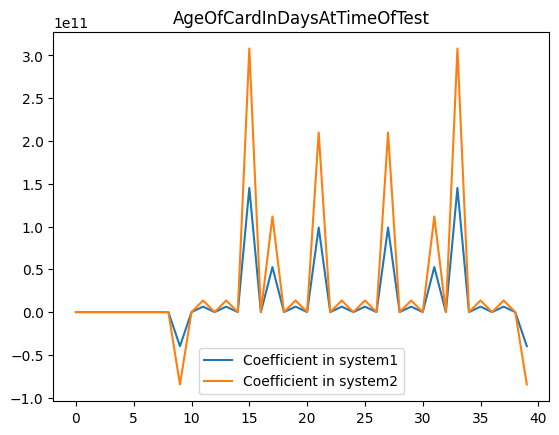


 For blood_sample_window
Sensor B
[ 2.05019537e+13 -1.16117015e+14  1.47983835e+00 -4.73849246e+13
 -1.48939195e+00  2.13471661e+13  1.67769110e+00 -4.73849246e+13
  8.44291213e+00 -1.16117015e+14  2.49566227e+00 -4.73849246e+13
  3.58565542e+00  2.13471661e+13  1.70996452e+00 -4.73849246e+13
 -1.32824292e+00 -1.16117015e+14 -2.89454558e+00 -4.73849246e+13
  2.22883796e+00 -1.16117015e+14 -1.68818682e+00 -4.73849246e+13
 -3.18001401e+00  2.13471661e+13 -6.39984636e+00 -4.73849246e+13
 -3.13489463e+00 -1.16117015e+14  1.23356488e+00 -4.73849246e+13
  1.54314487e+00  2.13471661e+13 -7.14122127e+00 -4.73849246e+13
  1.33622167e+00 -1.16117015e+14 -4.66698371e+00 -9.47698491e+13]


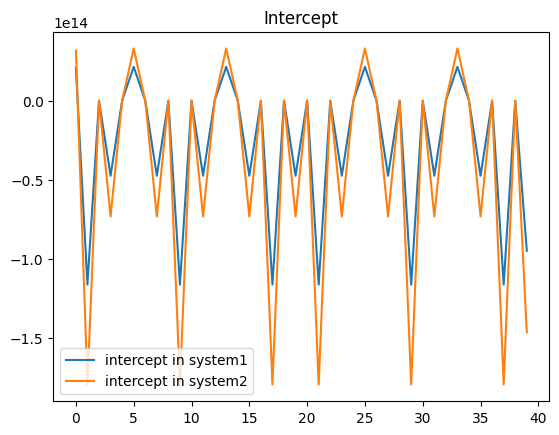

[-4.84150746e+11  2.74208695e+12 -7.67629935e-02  1.11898832e+12
  6.48301335e-02 -5.04110319e+11 -7.62127412e-02  1.11898832e+12
 -3.82964817e-01  2.74208695e+12 -1.23848962e-01  1.11898832e+12
 -1.59589546e-01 -5.04110319e+11 -7.92630868e-02  1.11898832e+12
  5.92697039e-02  2.74208695e+12  1.21625100e-01  1.11898832e+12
 -1.02564874e-01  2.74208695e+12  7.23058538e-02  1.11898832e+12
  1.44371542e-01 -5.04110319e+11  2.84899811e-01  1.11898832e+12
  1.41155785e-01  2.74208695e+12 -6.00961946e-02  1.11898832e+12
 -7.28645077e-02 -5.04110319e+11  3.15368146e-01  1.11898832e+12
 -6.31089668e-02  2.74208695e+12  2.10196983e-01  2.23797663e+12]


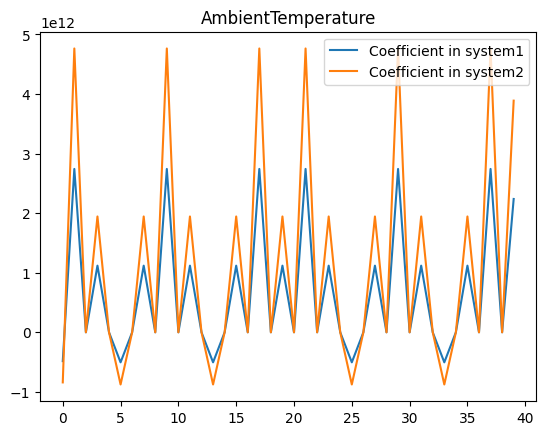

[-1.21003002e+10  6.85325295e+10  1.92757043e-05  2.79666915e+10
  1.38503011e-04 -1.25991465e+10 -2.57463315e-04  2.79666915e+10
 -7.25109837e-04  6.85325295e+10  2.64453074e-04  2.79666915e+10
 -3.87529024e-04 -1.25991465e+10  7.34149085e-05  2.79666915e+10
  2.06545674e-04  6.85325295e+10  6.76102021e-04  2.79666915e+10
 -2.46255435e-05  6.85325295e+10  5.59183675e-04  2.79666915e+10
  8.22421579e-05 -1.25991465e+10  5.40724568e-04  2.79666915e+10
  2.73300711e-04  6.85325295e+10  1.63948660e-04  2.79666915e+10
  4.85221694e-05 -1.25991465e+10  8.18474201e-04  2.79666915e+10
  1.19504509e-04  6.85325295e+10  2.56957126e-04  5.59333829e+10]


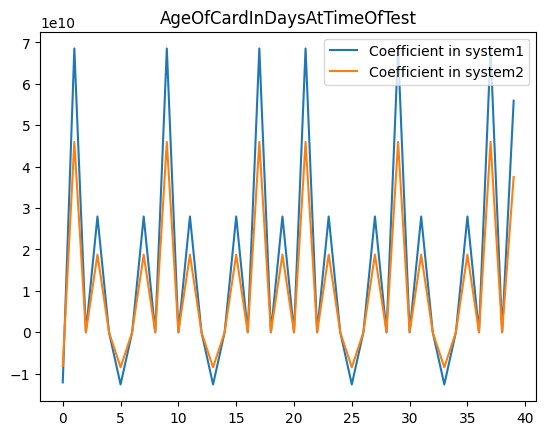


 For aqueous_sample_window
[ 1.00162326e+13 -5.67289855e+13 -4.11490029e+00 -2.31499121e+13
 -1.21908455e+01  1.04291612e+13  9.32005497e+00 -2.31499121e+13
  3.14460276e+00 -5.67289855e+13 -1.94462762e+01 -2.31499121e+13
  9.88128268e+00  1.04291612e+13  3.07382694e+00 -2.31499121e+13
  3.54757115e+00 -5.67289855e+13 -9.12845898e+00 -2.31499121e+13
  1.84153459e+00 -5.67289855e+13  8.14023020e+00 -2.31499121e+13
  6.63385500e+00  1.04291612e+13  2.04304129e+00 -2.31499121e+13
  1.80235568e+00 -5.67289855e+13 -1.85296512e+00 -2.31499121e+13
  5.58045983e-01  1.04291612e+13 -1.27964882e-01 -2.31499121e+13
 -7.51458979e+00 -5.67289855e+13  5.26284401e-01 -4.62998242e+13]


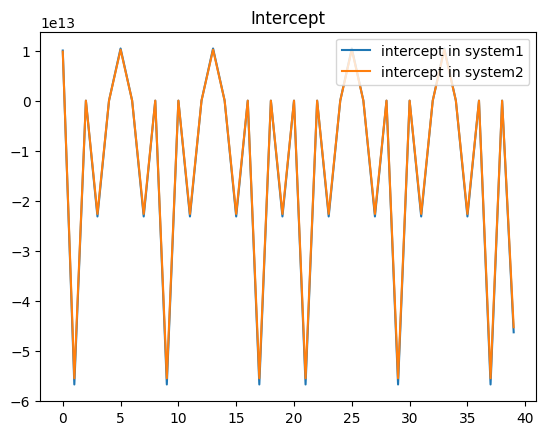

[-5.18902513e+10  2.93891070e+11  1.76251166e-01  1.19930797e+11
  5.48006801e-01 -5.40294760e+10 -4.20549239e-01  1.19930797e+11
 -1.46166707e-01  2.93891070e+11  8.67652850e-01  1.19930797e+11
 -4.44047520e-01 -5.40294760e+10 -1.39683845e-01  1.19930797e+11
 -1.60019530e-01  2.93891070e+11  4.04573150e-01  1.19930797e+11
 -8.39495217e-02  2.93891070e+11 -3.69587061e-01  1.19930797e+11
 -2.99199737e-01 -5.40294760e+10 -9.48531601e-02  1.19930797e+11
 -8.15253051e-02  2.93891070e+11  8.11122996e-02  1.19930797e+11
 -2.83579525e-02 -5.40294760e+10  1.52102186e-03  1.19930797e+11
  3.36342017e-01  2.93891070e+11 -2.45717756e-02  2.39861594e+11]


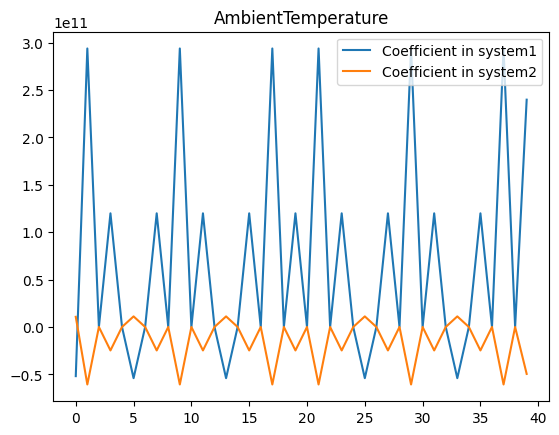

[-8.07046027e+09  4.57087053e+10  3.76745518e-04  1.86527663e+10
  6.85721951e-04 -8.40317263e+09 -7.32604322e-04  1.86527663e+10
  8.35967616e-05  4.57087053e+10  1.24540253e-03  1.86527663e+10
 -6.88101992e-04 -8.40317263e+09 -2.04282973e-04  1.86527663e+10
 -2.01656236e-04  4.57087053e+10  7.06577829e-04  1.86527663e+10
 -1.02437831e-04  4.57087053e+10 -3.54040459e-04  1.86527663e+10
 -4.14800375e-04 -8.40317263e+09 -1.07259183e-04  1.86527663e+10
 -6.98801850e-05  4.57087053e+10  5.31169840e-05  1.86527663e+10
  9.38855864e-05 -8.40317263e+09 -2.54743071e-06  1.86527663e+10
  5.96495063e-04  4.57087053e+10  1.30916446e-05  3.73055327e+10]


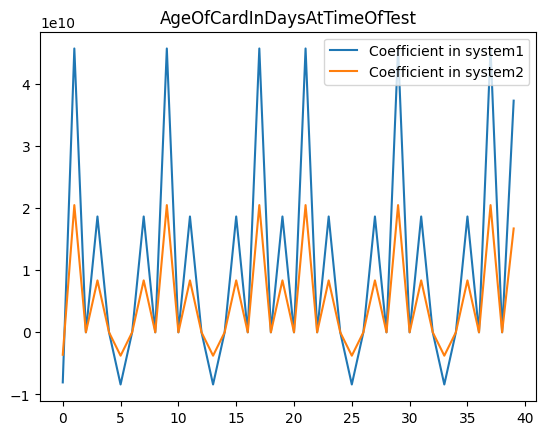

In [43]:
# Regression plot
# print("\n","For cal_window")
print("Sensor A")
coefficent_visualization(A1_cal_window_funct_reg,A2_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],interval=range(1,39))
print("\n","For blood_cal_window")
coefficent_visualization(A1_blood_cal_window_funct_reg,A2_blood_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],interval=range(1,39))
print("\n","For aqueous_cal_window")
coefficent_visualization(A1_aquous_cal_window_funct_reg,A2_aquous_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],interval=range(1,39))
print("\n","For blood_cal_window")
print("Sensor B")
coefficent_visualization(B1_blood_cal_window_funct_reg,B2_blood_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],interval=range(1,40))
print("\n","For aqueous_cal_window")
coefficent_visualization(B1_aquous_cal_window_funct_reg,B2_aquous_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],interval=range(1,40))


print("\n","For sample_window")
print("Sensor A")
coefficent_visualization(A1_sample_window_funct_reg,A2_sample_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],interval=range(0,40))
print("\n","For blood_sample_window")
coefficent_visualization(A1_blood_sample_window_funct_reg,A2_blood_sample_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],interval=range(0,40))
print("\n","For aqueous_sample_window")
coefficent_visualization(A1_aquous_sample_window_funct_reg,A2_aquous_sample_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],interval=range(0,40))
print("\n","For blood_sample_window")
print("Sensor B")
coefficent_visualization(B1_blood_sample_window_funct_reg,B2_blood_sample_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],interval=range(0,40))
print("\n","For aqueous_sample_window")
coefficent_visualization(B1_aquous_sample_window_funct_reg,B2_aquous_sample_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],interval=range(0,40))

